In [1]:
# wide screen
from IPython.core.display import display, HTML
from IPython import get_ipython as get_ipython
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important;margin-left:-30px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

In [2]:
import tqdm
import math
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('./data/clasdb_pi_plus_n.txt', delimiter='\t', header=None)
df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']

df.loc[8314:65671, 'Ebeam'] = 5.754
df['phi'] = df.phi.apply(lambda x: math.radians(x))
df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]

In [4]:
feature_data = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']]
label_data = df['dsigma_dOmega']

model = torch.load('./models/5_60_layers')

scaler_feature = StandardScaler()
scaler_target = StandardScaler()
scaler_feature.fit(feature_data)
scaler_target.fit(label_data.values.reshape(-1,1))

StandardScaler()

# extract structure functions

In [98]:
Ebeam = 5.499
step_W = 0.01
step_Q2 = 0.1
step_cos_theta = 0.1
step_phi = 0.05

In [99]:
data_grid = []
for W in tqdm.tqdm(np.arange(1.2, 2.0 + step_W, step_W)):
    for Q2 in np.arange(0.1, 4.5 + step_Q2, step_Q2):
         for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                for phi in np.arange(0, 2*np.pi, step_phi):
                    data_grid.append([Ebeam,
                                      W,
                                      Q2,
                                      cos_theta, 
                                      phi])
                    
df_grid = pd.DataFrame(data_grid)
df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']

100%|██████████| 81/81 [00:09<00:00,  8.46it/s]


In [100]:
df_grid.W = np.round(df_grid.W, 3)
df_grid.Q2 = np.round(df_grid.Q2, 3)
df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
df_grid.phi = np.round(df_grid.phi, 3)

In [101]:
with torch.no_grad():
    dsigma_dOmega_predicted = scaler_target.inverse_transform(model(torch.tensor(scaler_feature.transform(df_grid)).to(torch.float32)))

df_grid['dsigma_dOmega_predicted'] = dsigma_dOmega_predicted
df_grid.dsigma_dOmega_predicted = abs(df_grid.dsigma_dOmega_predicted)

In [102]:
df_grid['A'] = 0
df_grid['B'] = 0
df_grid['C'] = 0

phi_min_index = df_grid[df_grid.phi == df_grid.phi.min()].index.to_numpy()
phi_max_index = df_grid[df_grid.phi == df_grid.phi.max()].index.to_numpy()

In [103]:
for i in tqdm.tqdm(range(len(phi_min_index))):
    cross_section_chunk = df_grid.iloc[phi_min_index[i]:phi_max_index[i]].dsigma_dOmega_predicted
    cos_phi = np.cos(df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
    cos_2_phi = np.cos(2*df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
    
    trapz_A = np.trapz(cross_section_chunk, dx=step_phi)
    trapz_B = np.trapz(cross_section_chunk*cos_2_phi, dx=step_phi)
    trapz_C = np.trapz(cross_section_chunk*cos_phi, dx=step_phi)
    
    A = trapz_A/(2*np.pi)
    B = trapz_B/(np.pi)
    C = trapz_C/(np.pi)
    
    df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
    df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
    df_grid.loc[phi_min_index[i]:phi_max_index[i], 'C'] = C

100%|██████████| 76545/76545 [01:08<00:00, 1115.66it/s]


# Plots time

# As a function of W

In [104]:
df[df.Ebeam == 5.499].Q2.unique()

array([1.8 , 2.2 , 2.6 , 3.15, 4.  ])

In [105]:
df_grid[df_grid.Ebeam == 5.499].Q2.unique()

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5])

In [118]:
Ebeam = 5.499
Q2_real = [1.8, 2.6, 3.15]
Q2_gen = [1.8, 2.6, 3.1]

cos_theta_gen = cos_theta_real = [-0.7, -0.1, 0.7]

In [119]:
def gen_ABC_W(Ebeam, Q2, cos_theta):
    
    df_tmp = df_grid[(df_grid.Ebeam == Ebeam)&
                    (df_grid.Q2 == Q2)&
                    (df_grid.cos_theta == cos_theta)].drop(['phi', 'dsigma_dOmega_predicted'], axis=1).drop_duplicates()
    
    return df_tmp

In [120]:
def real_ABC_W(Ebeam, Q2, cos_theta):
    
    def func_cos(x, a, b, c): 
        return a + b*np.cos(2*x) + c*np.cos(x) 
    
    def get_real_abc(phi, dsigma_dOmega):
        xdata = phi
        ydata = dsigma_dOmega 
        popt, pcov = curve_fit(func_cos, xdata, ydata) 
        a, b, c = popt[0], popt[1], popt[2]
    
        return [a, b, c]
    
    df_tmp_real = df[(df.Ebeam == Ebeam)&
                (df.Q2 == Q2)&
                (df.cos_theta == cos_theta)].drop_duplicates()
    
    df_W_abc = df_tmp_real.groupby('W').apply(lambda x: get_real_abc(x.phi, x.dsigma_dOmega)).reset_index()
    df_W_abc['A'] = df_W_abc[0].apply(lambda x: x[0])
    df_W_abc['B'] = df_W_abc[0].apply(lambda x: x[1])
    df_W_abc['C'] = df_W_abc[0].apply(lambda x: x[2])
    
    return df_W_abc

In [121]:
def plot_gen_real(params_gen, params_real):
    
    df_ABC_W_gen = gen_ABC_W(**params_gen)
    df_ABC_W_real = real_ABC_W(**params_real)
    
    
    plt.figure(figsize=(28, 12), dpi=80)

    plt.scatter(df_ABC_W_gen.W, df_ABC_W_gen.A, label= 'A', color='red', s=20, marker='v')
    plt.scatter(df_ABC_W_gen.W, df_ABC_W_gen.B, label= 'B', color='green', s=20, marker='v')
    plt.scatter(df_ABC_W_gen.W, df_ABC_W_gen.C, label= 'C', color='blue', s=20, marker='v')

    plt.scatter(df_ABC_W_real.W[1:], df_ABC_W_real.A[1:], label= 'A real', color='red', marker='^')
    plt.scatter(df_ABC_W_real.W[1:], df_ABC_W_real.B[1:], label= 'B real', color='green', marker='^')
    plt.scatter(df_ABC_W_real.W[1:], df_ABC_W_real.C[1:], label= 'C real', color='blue', marker='^')

    plt.xlabel("W")
    plt.ylabel("A/B/C")
    plt.title(f'Plot of structure functions. Params gen: {params_gen}. Params real: {params_real}')
    plt.legend()
    plt.show()

In [122]:
# test params

# params_gen = {'Ebeam' : 5.754,
#             'Q2' : 1.7,
#             'cos_theta' : -0.1}

# params_real = {'Ebeam' : 5.754,
#             'Q2' : 1.715,
#             'cos_theta' : -0.1}

# plot_gen_real(params_gen, params_real)

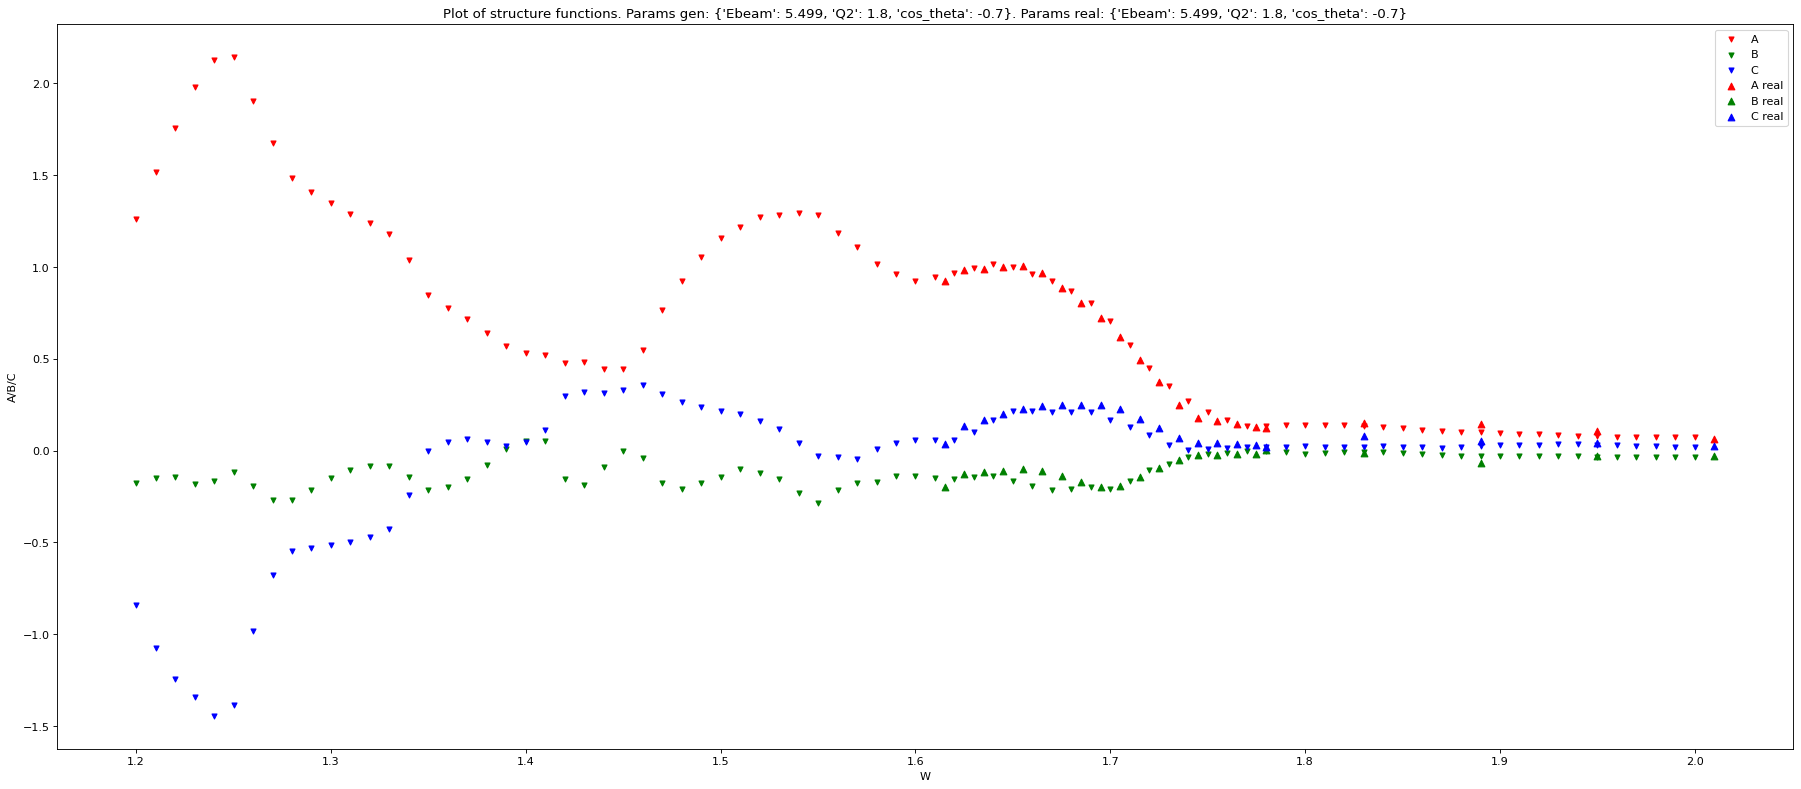

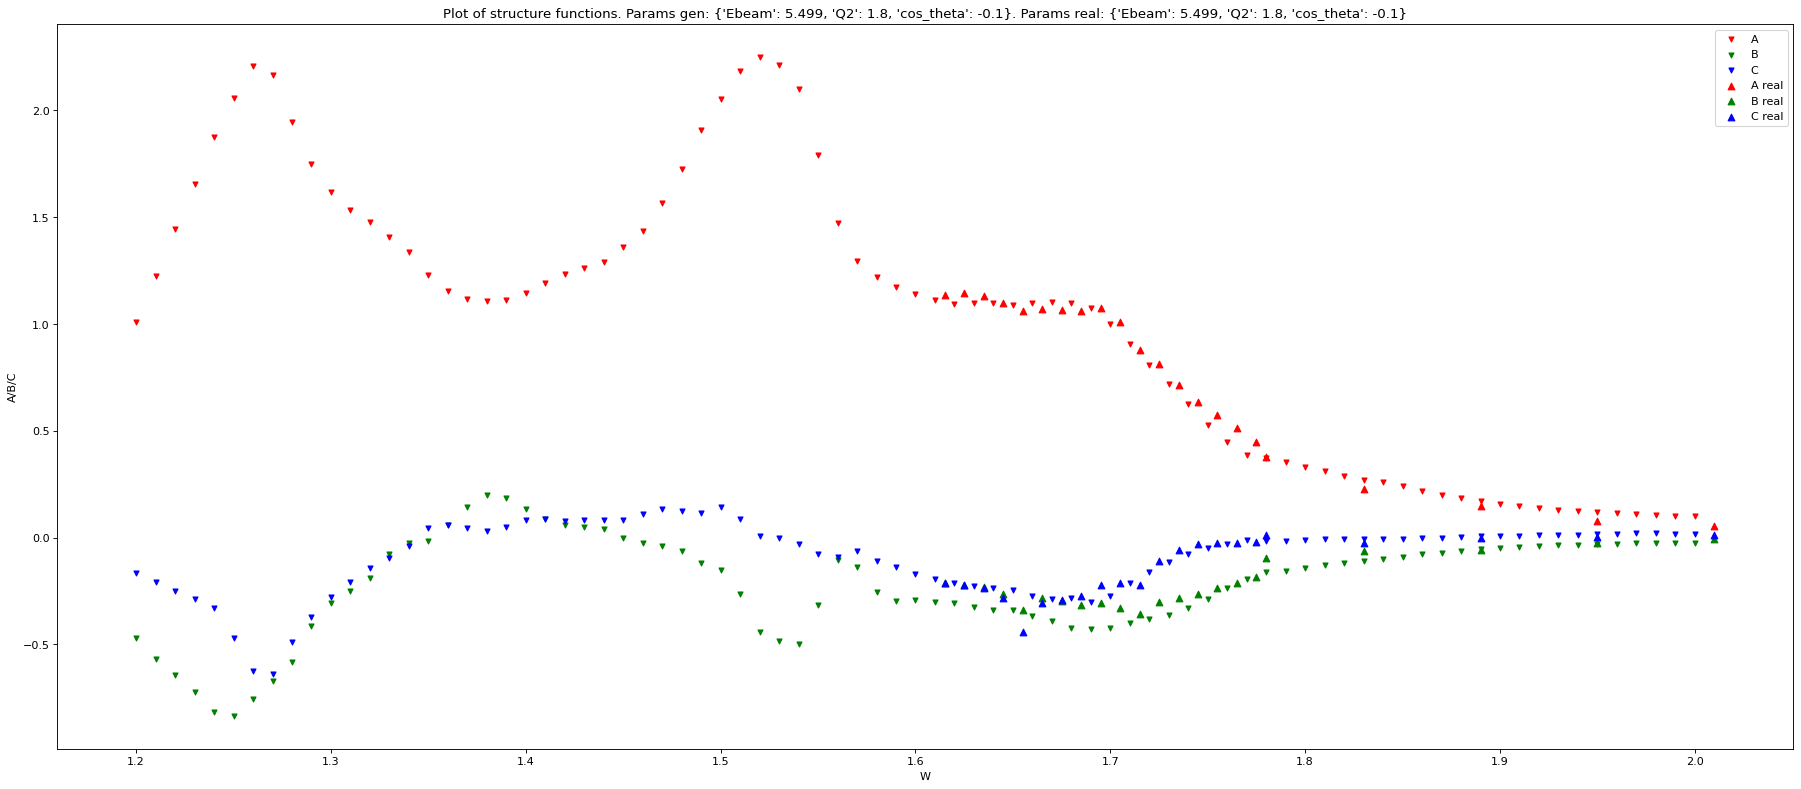

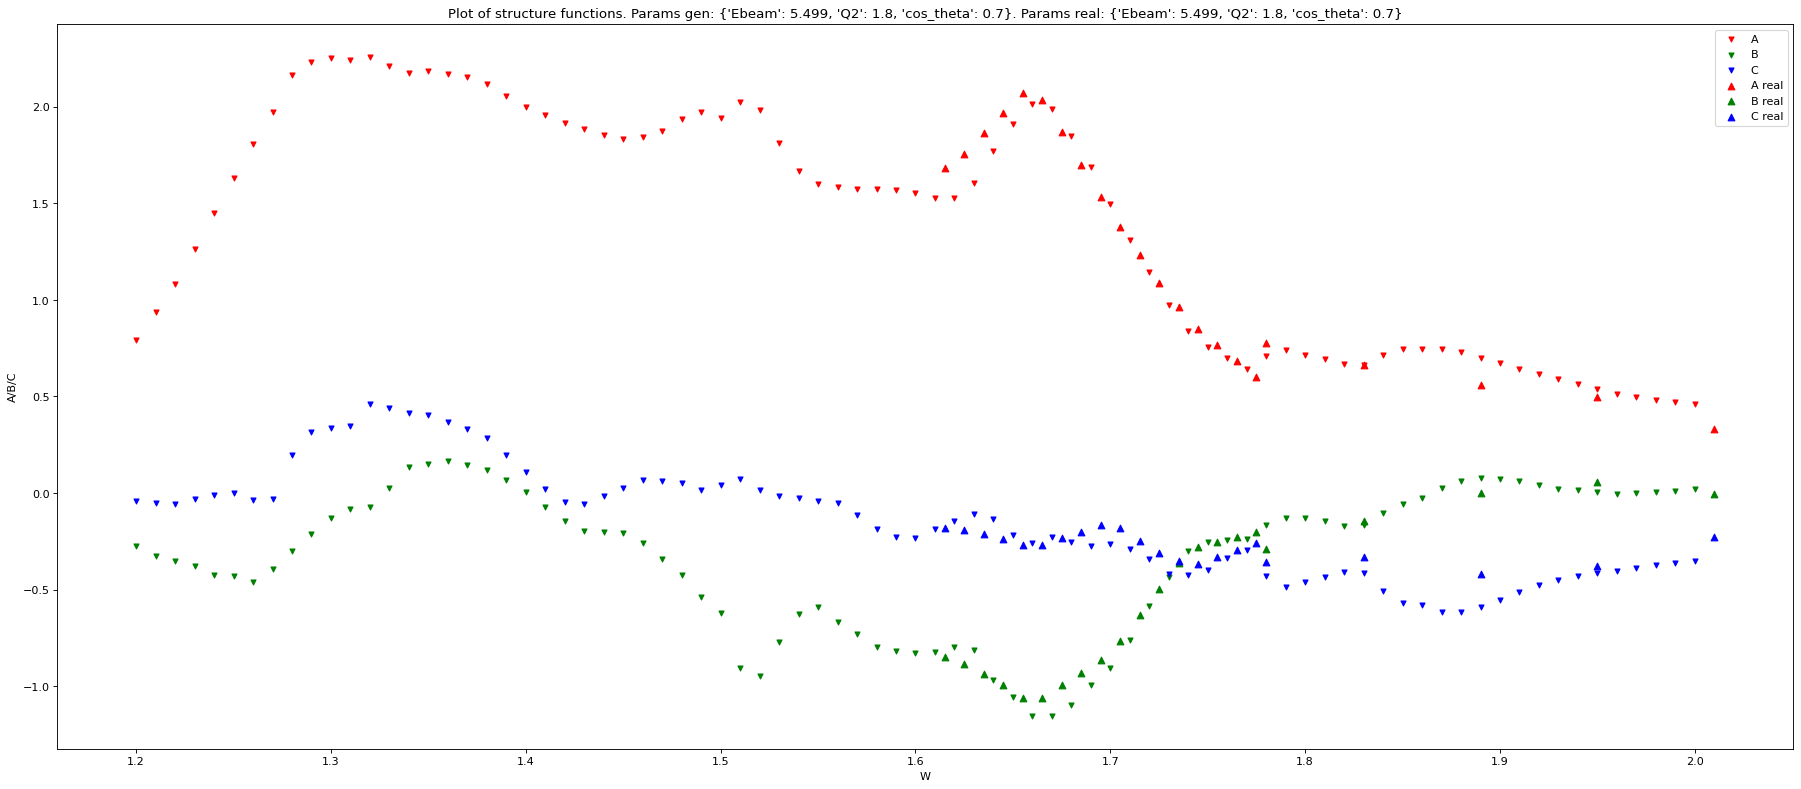

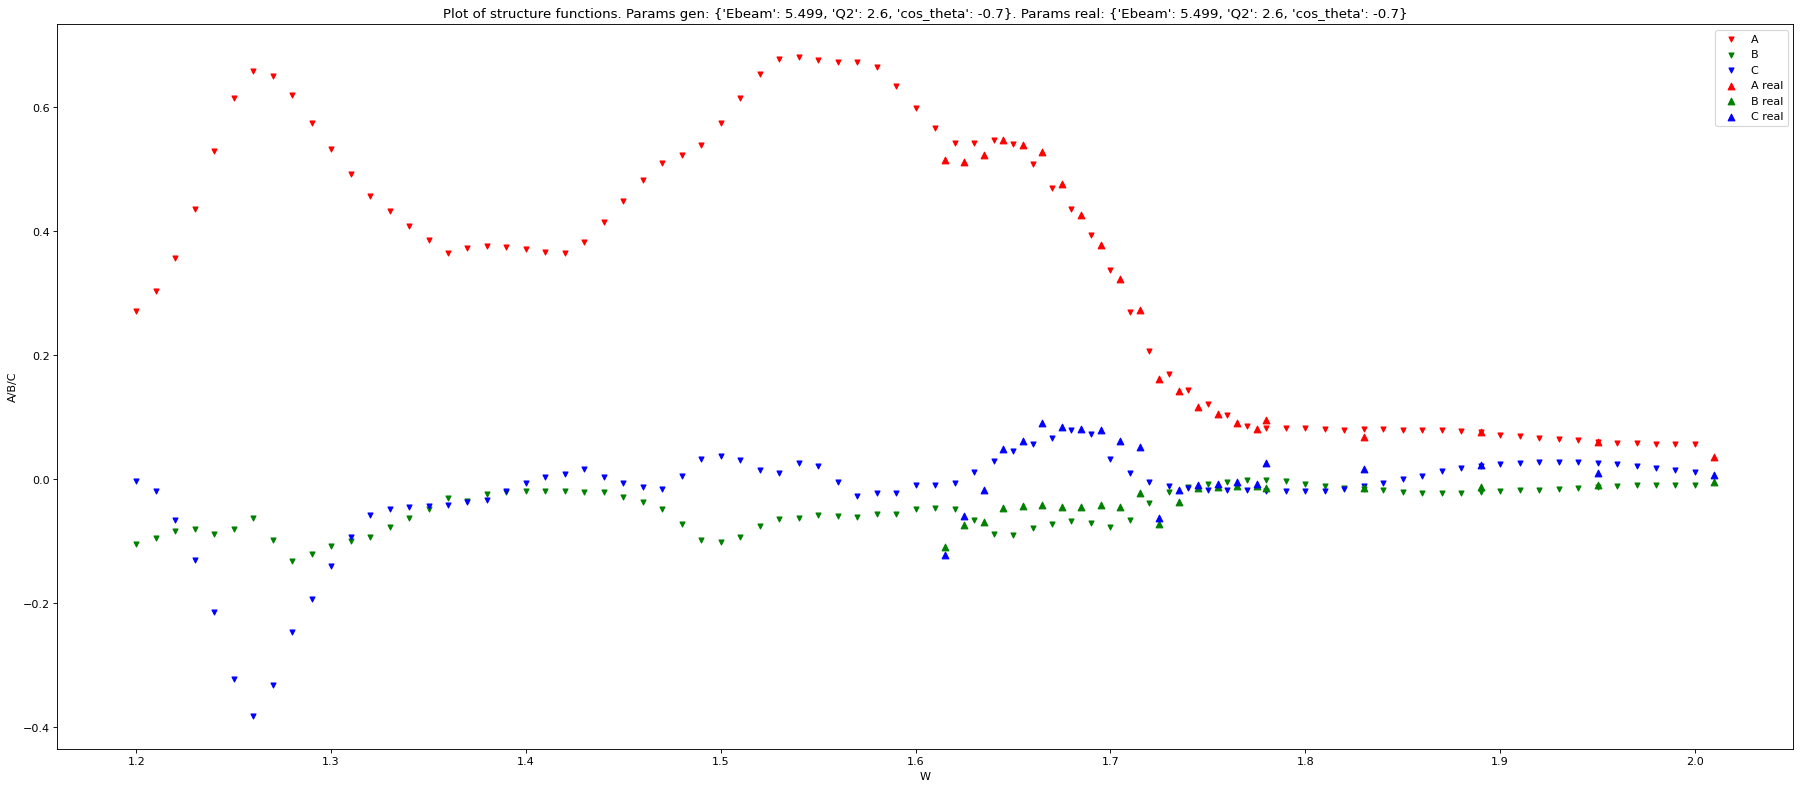

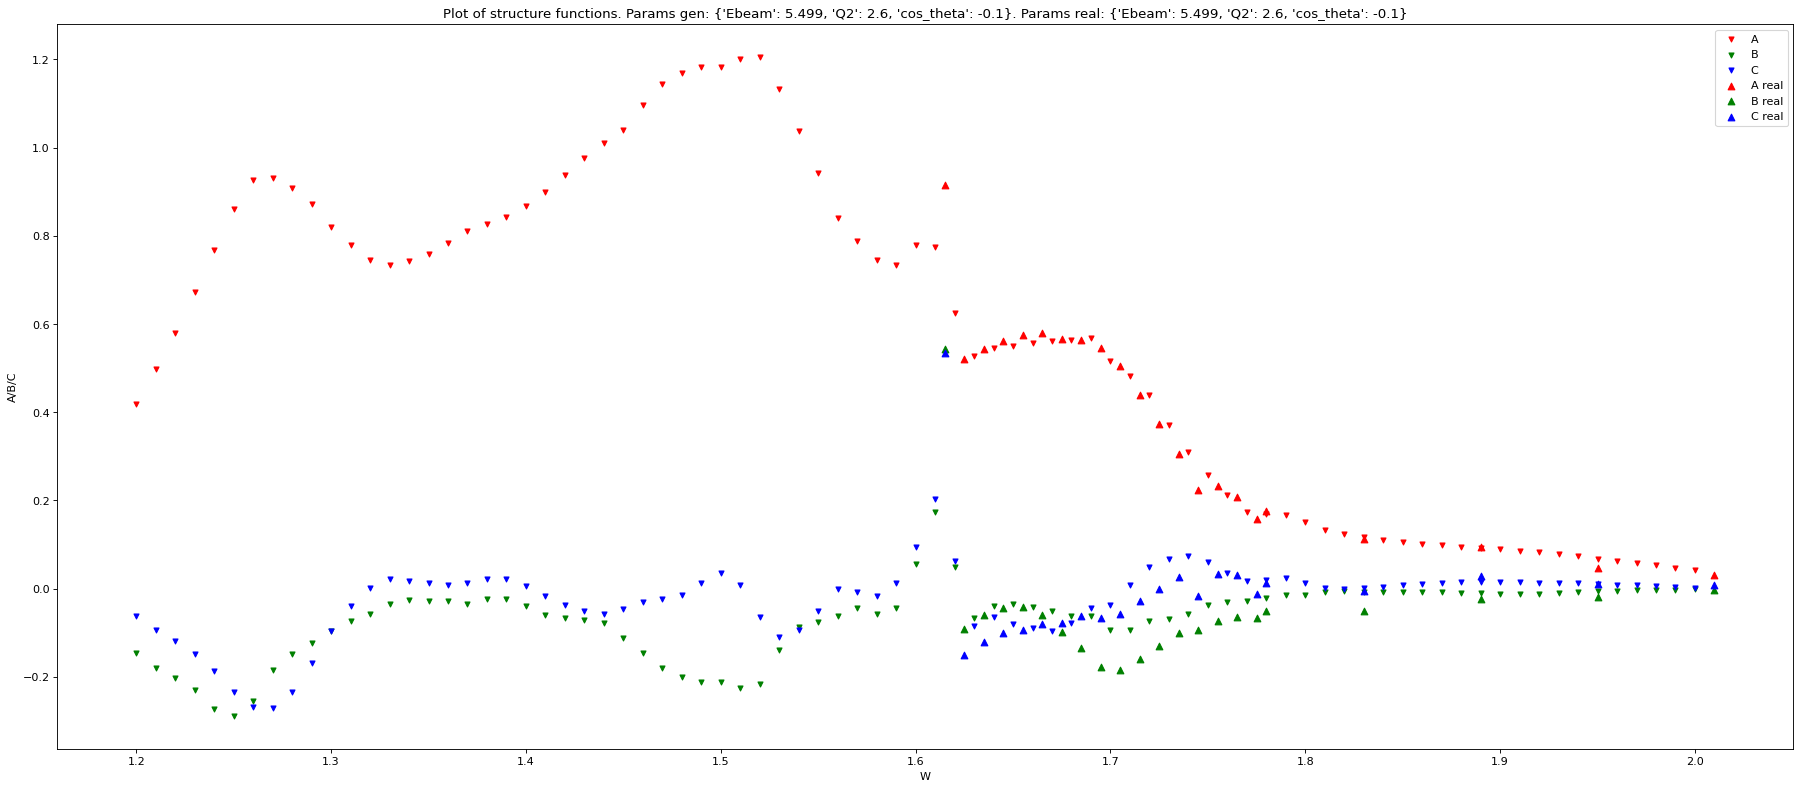

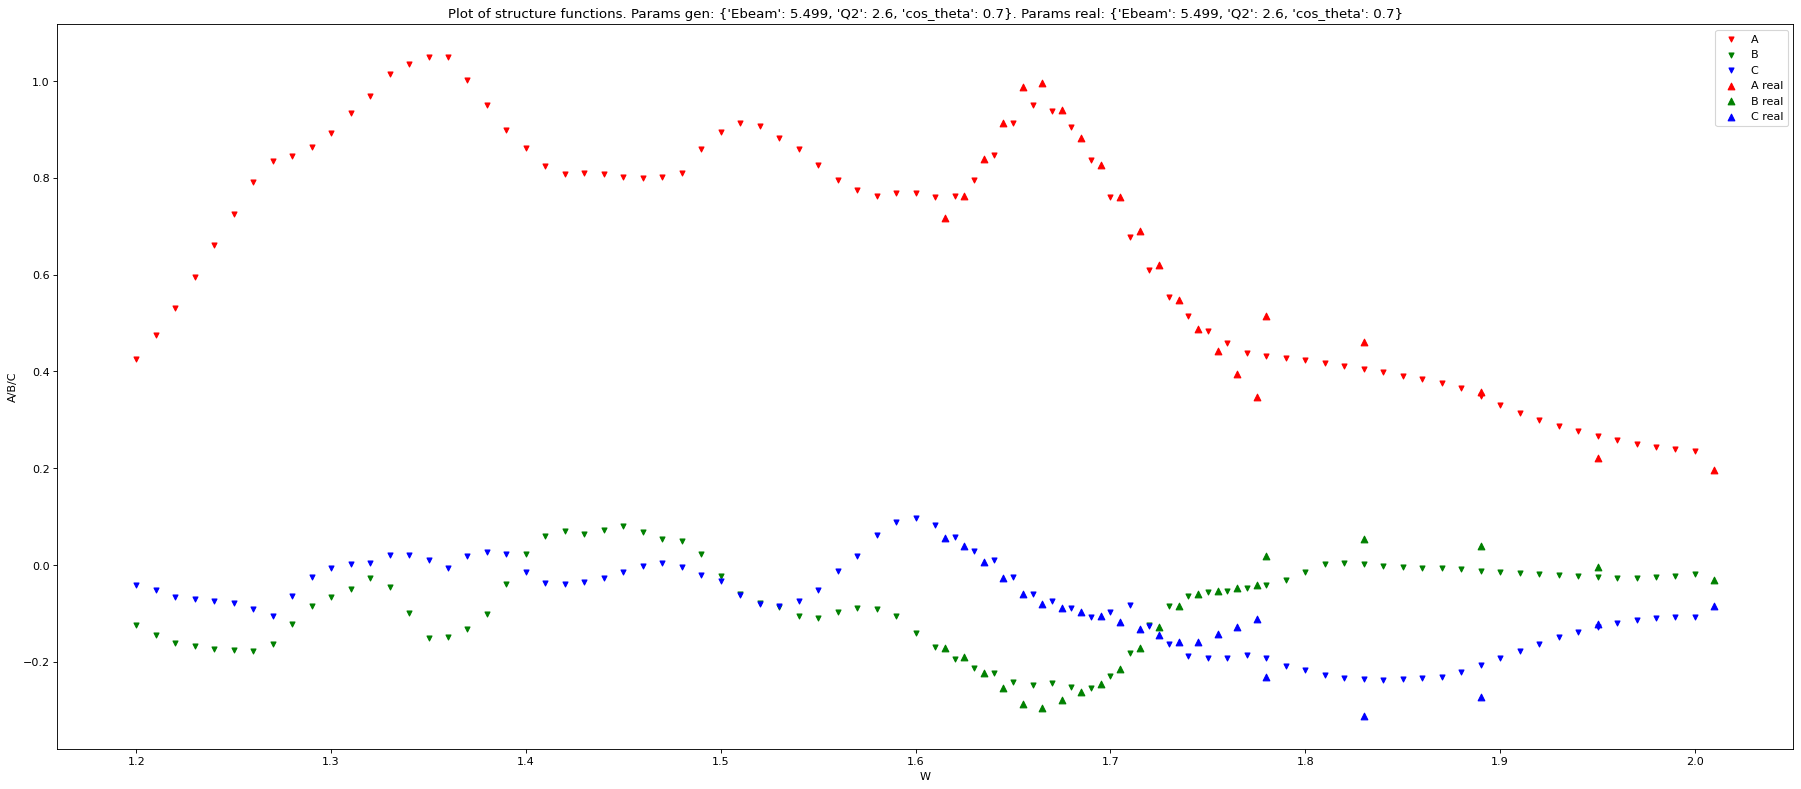

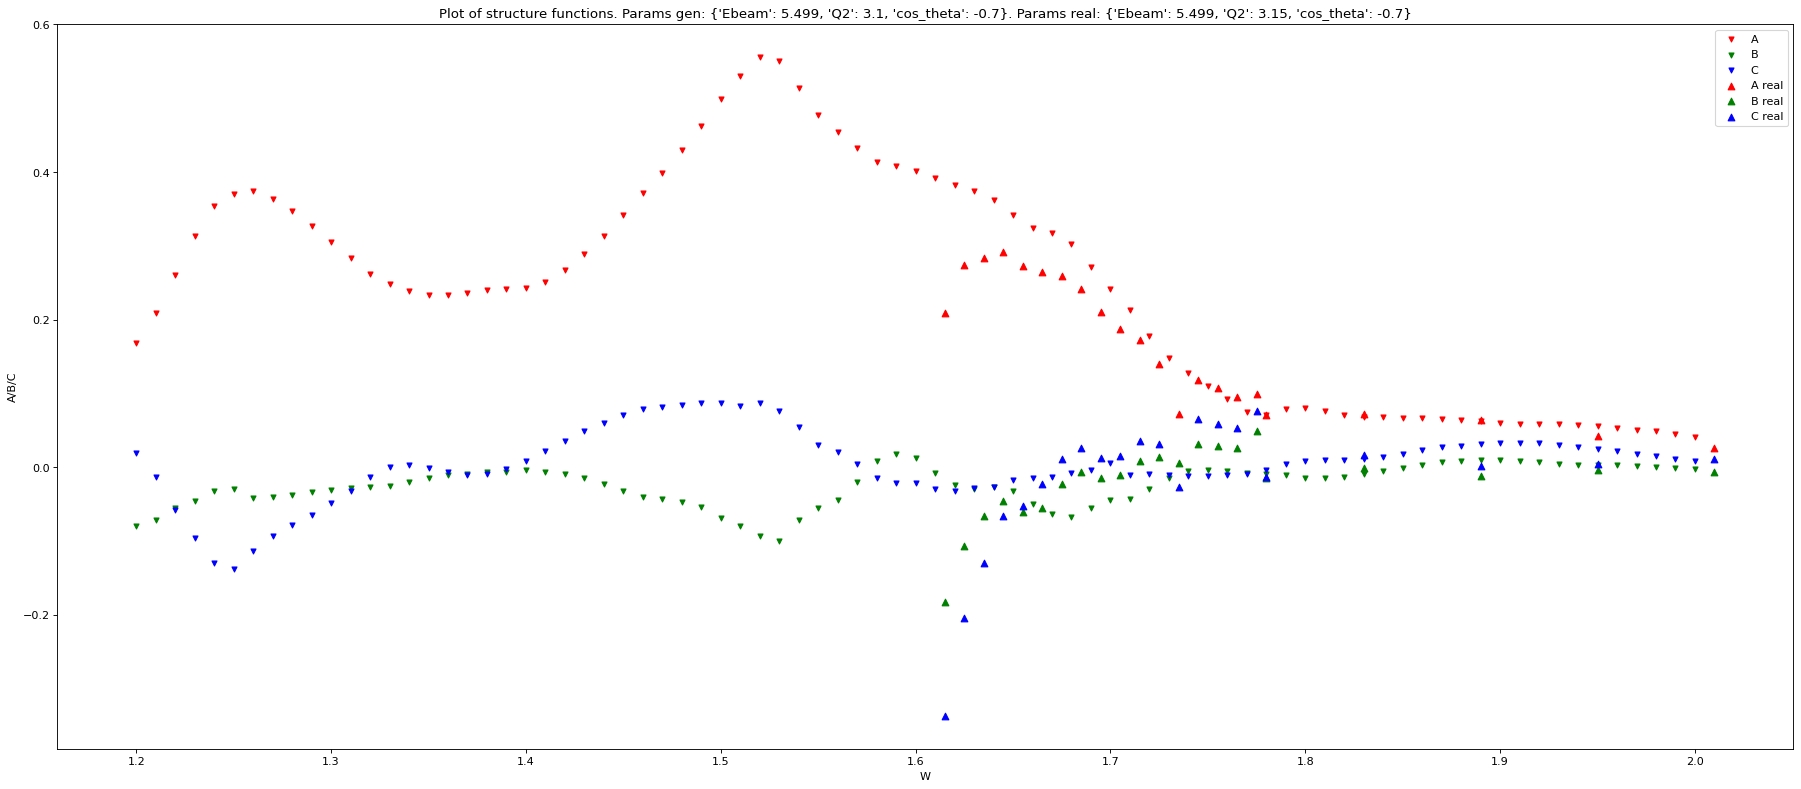

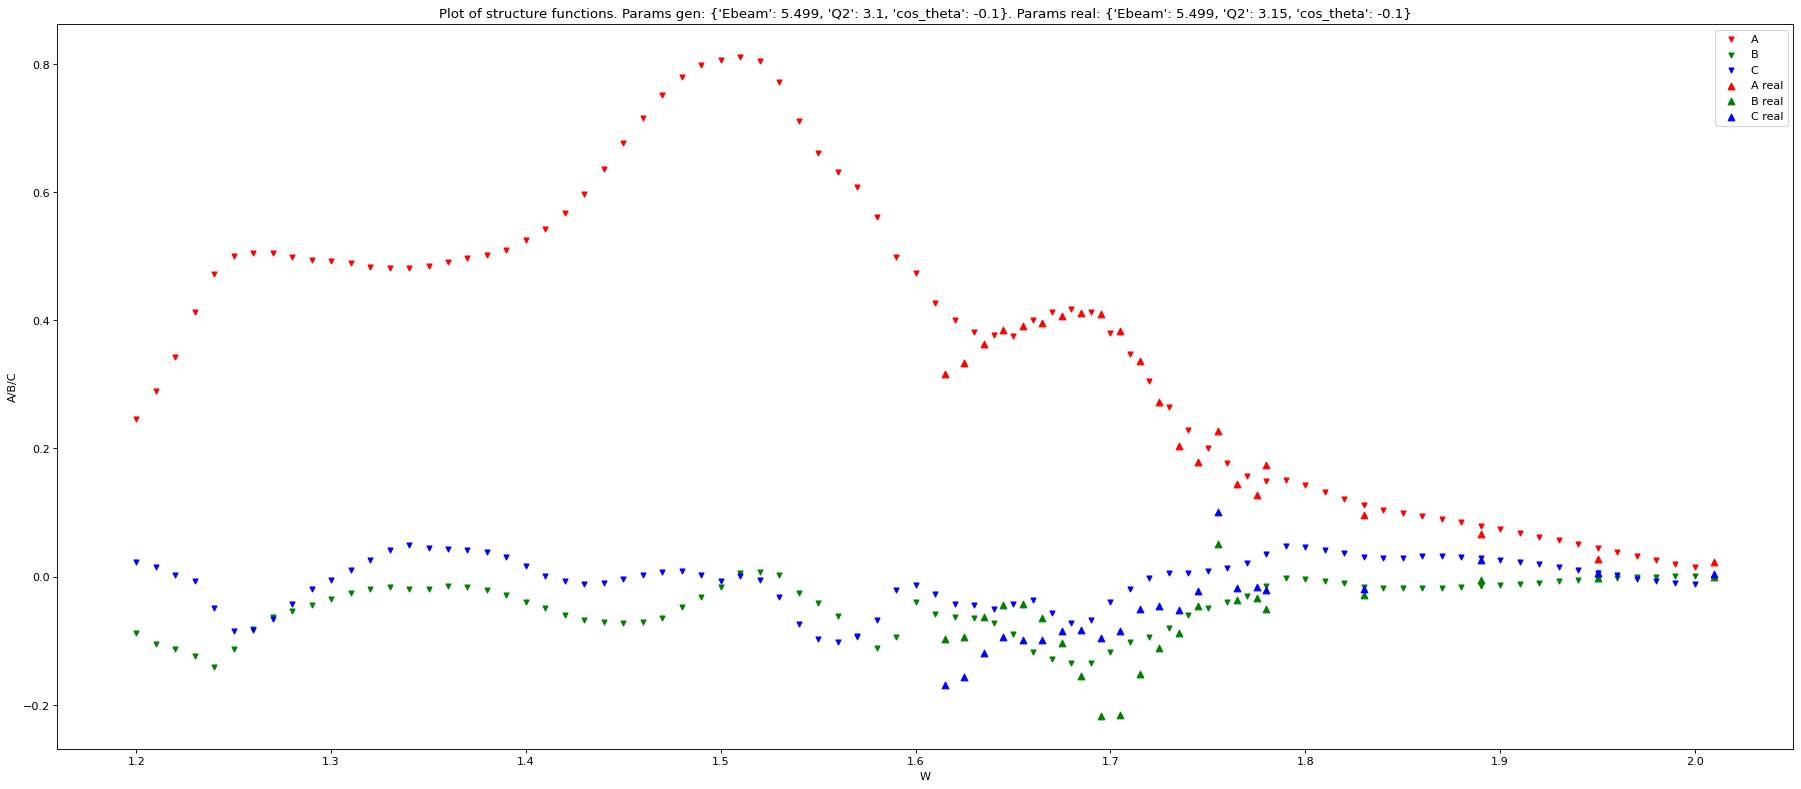

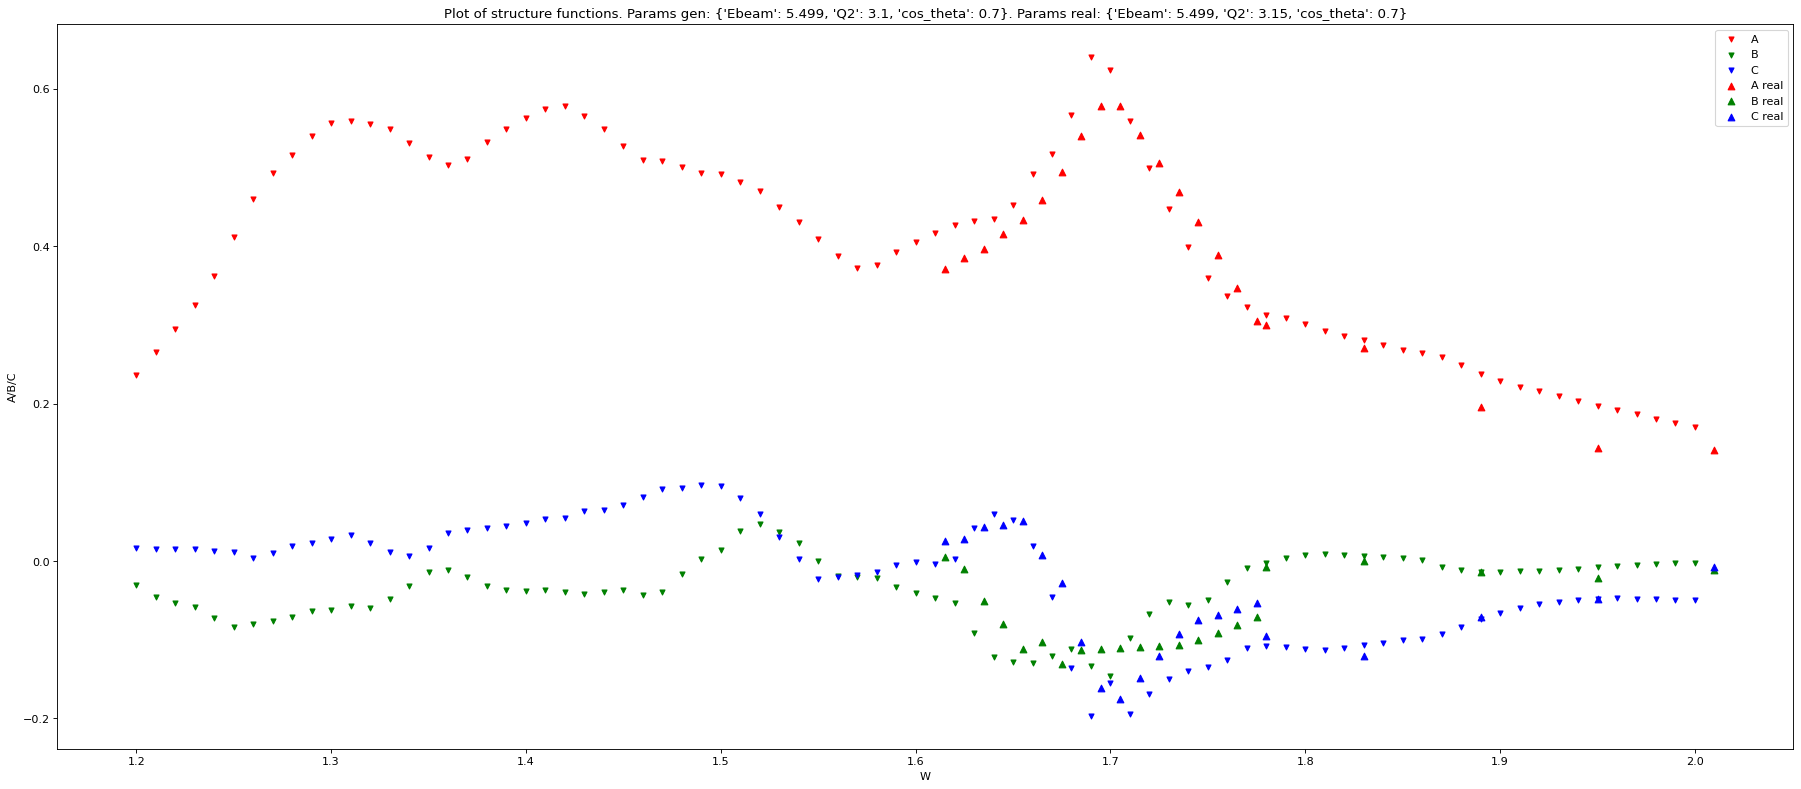

In [123]:
for i in range(3):
    for j in range(3):
        params_gen = {'Ebeam' : Ebeam,
                    'Q2' : Q2_gen[i],
                    'cos_theta' : cos_theta_gen[j]}

        params_real = {'Ebeam' : Ebeam,
                    'Q2' : Q2_real[i],
                    'cos_theta' : cos_theta_real[j]}
        plot_gen_real(params_gen, params_real)

# As a function of Q2

In [129]:
np.sort(df[df.Ebeam == 5.499].W.unique())

array([1.605, 1.615, 1.62 , 1.625, 1.635, 1.645, 1.655, 1.66 , 1.665,
       1.675, 1.685, 1.695, 1.7  , 1.705, 1.715, 1.725, 1.735, 1.74 ,
       1.745, 1.755, 1.765, 1.775, 1.78 , 1.83 , 1.89 , 1.95 , 2.01 ])

In [125]:
df_grid[df_grid.Ebeam == 5.499].W.unique()

array([1.2 , 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 ,
       1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41,
       1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.51, 1.52,
       1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6 , 1.61, 1.62, 1.63,
       1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.7 , 1.71, 1.72, 1.73, 1.74,
       1.75, 1.76, 1.77, 1.78, 1.79, 1.8 , 1.81, 1.82, 1.83, 1.84, 1.85,
       1.86, 1.87, 1.88, 1.89, 1.9 , 1.91, 1.92, 1.93, 1.94, 1.95, 1.96,
       1.97, 1.98, 1.99, 2.  ])

In [159]:
 df[(df.Ebeam == Ebeam)&
    (df.W == 1.62)].cos_theta.unique()

array([0.525, 0.575, 0.625, 0.675, 0.725, 0.775, 0.825, 0.875, 0.925,
       0.975])

In [167]:
W_real = [1.62, 1.7, 1.95]
W_gen = [1.62, 1.7, 1.95]
cos_theta_gen = [0.5, 0.6, 0.7]
cos_theta_real = [0.525, 0.625, 0.725]

In [168]:
def gen_ABC_Q2(Ebeam, W, cos_theta):
    
    df_tmp = df_grid[(df_grid.Ebeam == Ebeam)&
                    (df_grid.W == W)&
                    (df_grid.cos_theta == cos_theta)].drop(['phi', 'dsigma_dOmega_predicted'], axis=1).drop_duplicates()
    
    return df_tmp

In [169]:
def real_ABC_Q2(Ebeam, W, cos_theta):
    
    def func_cos(x, a, b, c): 
        return a + b*np.cos(2*x) + c*np.cos(x) 
    
    def get_real_abc(phi, dsigma_dOmega):
        xdata = phi
        ydata = dsigma_dOmega 
        popt, pcov = curve_fit(func_cos, xdata, ydata) 
        a, b, c = popt[0], popt[1], popt[2]
    
        return [a, b, c]
    
    df_tmp_real = df[(df.Ebeam == Ebeam)&
                (df.W == W)&
                (df.cos_theta == cos_theta)].drop_duplicates()
    
    df_Q2_abc = df_tmp_real.groupby('Q2').apply(lambda x: get_real_abc(x.phi, x.dsigma_dOmega)).reset_index()
    
    df_Q2_abc['A'] = df_Q2_abc[0].apply(lambda x: x[0])
    df_Q2_abc['B'] = df_Q2_abc[0].apply(lambda x: x[1])
    df_Q2_abc['C'] = df_Q2_abc[0].apply(lambda x: x[2])
    
    return df_Q2_abc

In [170]:
def plot_gen_real(params_gen, params_real):
    
    df_ABC_Q2_gen = gen_ABC_Q2(**params_gen)
    df_ABC_Q2_real = real_ABC_Q2(**params_real)
    
    
    plt.figure(figsize=(28, 12), dpi=80)

    plt.scatter(df_ABC_Q2_gen.Q2, df_ABC_Q2_gen.A, label= 'A', color='red', s=20, marker='v')
    plt.scatter(df_ABC_Q2_gen.Q2, df_ABC_Q2_gen.B, label= 'B', color='green', s=20, marker='v')
    plt.scatter(df_ABC_Q2_gen.Q2, df_ABC_Q2_gen.C, label= 'C', color='blue', s=20, marker='v')

    plt.scatter(df_ABC_Q2_real.Q2[1:], df_ABC_Q2_real.A[1:], label= 'A real', color='red', marker='^')
    plt.scatter(df_ABC_Q2_real.Q2[1:], df_ABC_Q2_real.B[1:], label= 'B real', color='green', marker='^')
    plt.scatter(df_ABC_Q2_real.Q2[1:], df_ABC_Q2_real.C[1:], label= 'C real', color='blue', marker='^')

    plt.xlabel("W")
    plt.ylabel("A/B/C")
    plt.title(f'Plot of structure functions. Params gen: {params_gen}. Params real: {params_real}')
    plt.legend()
    plt.show()

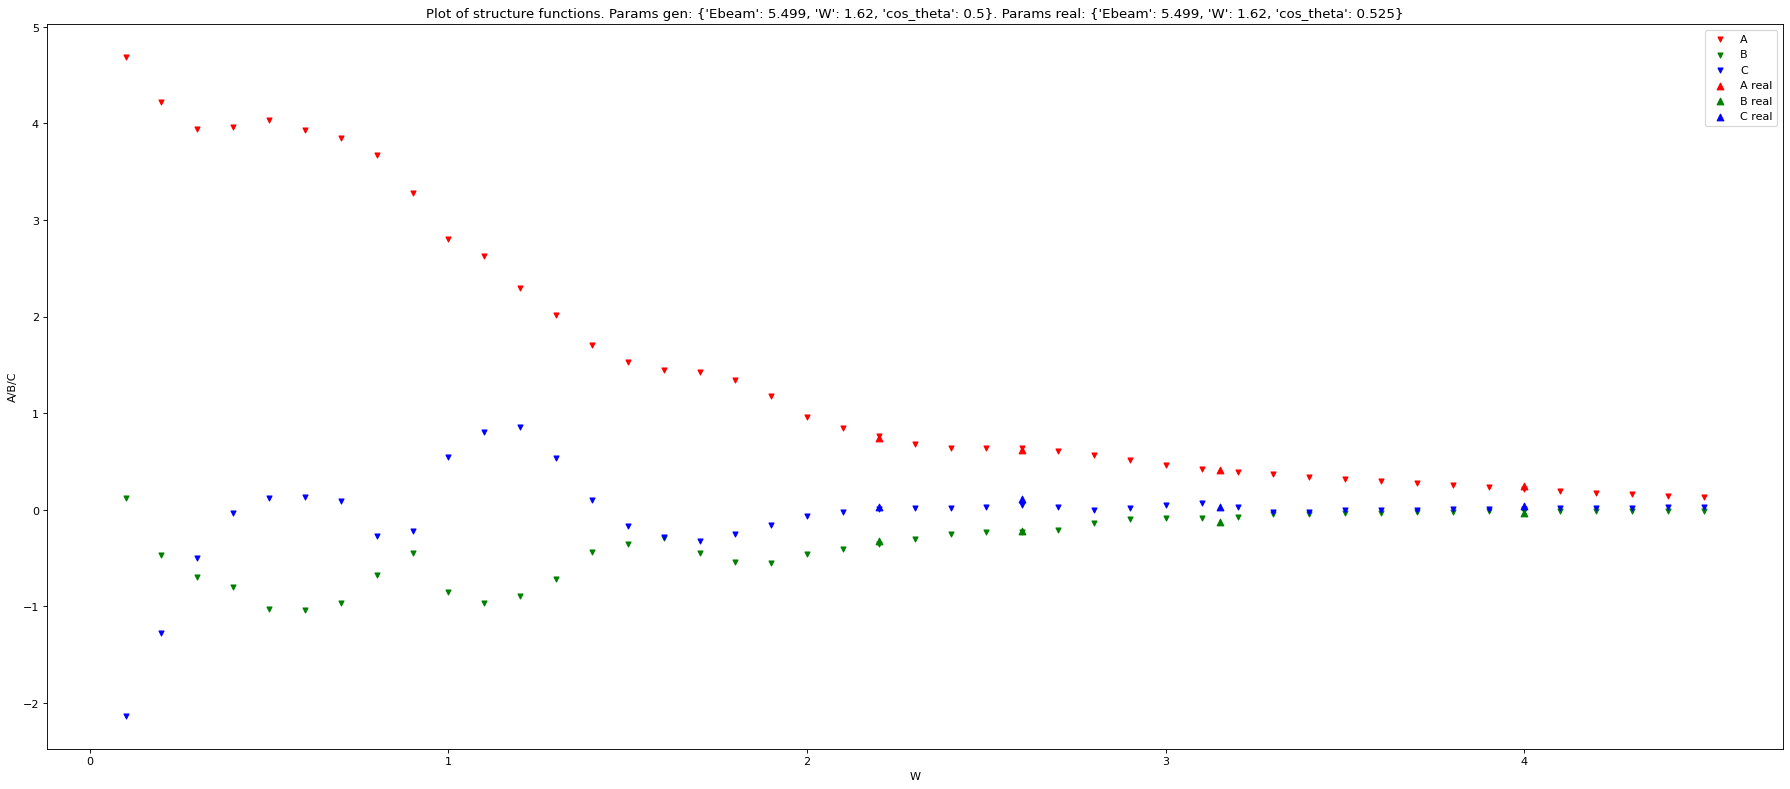

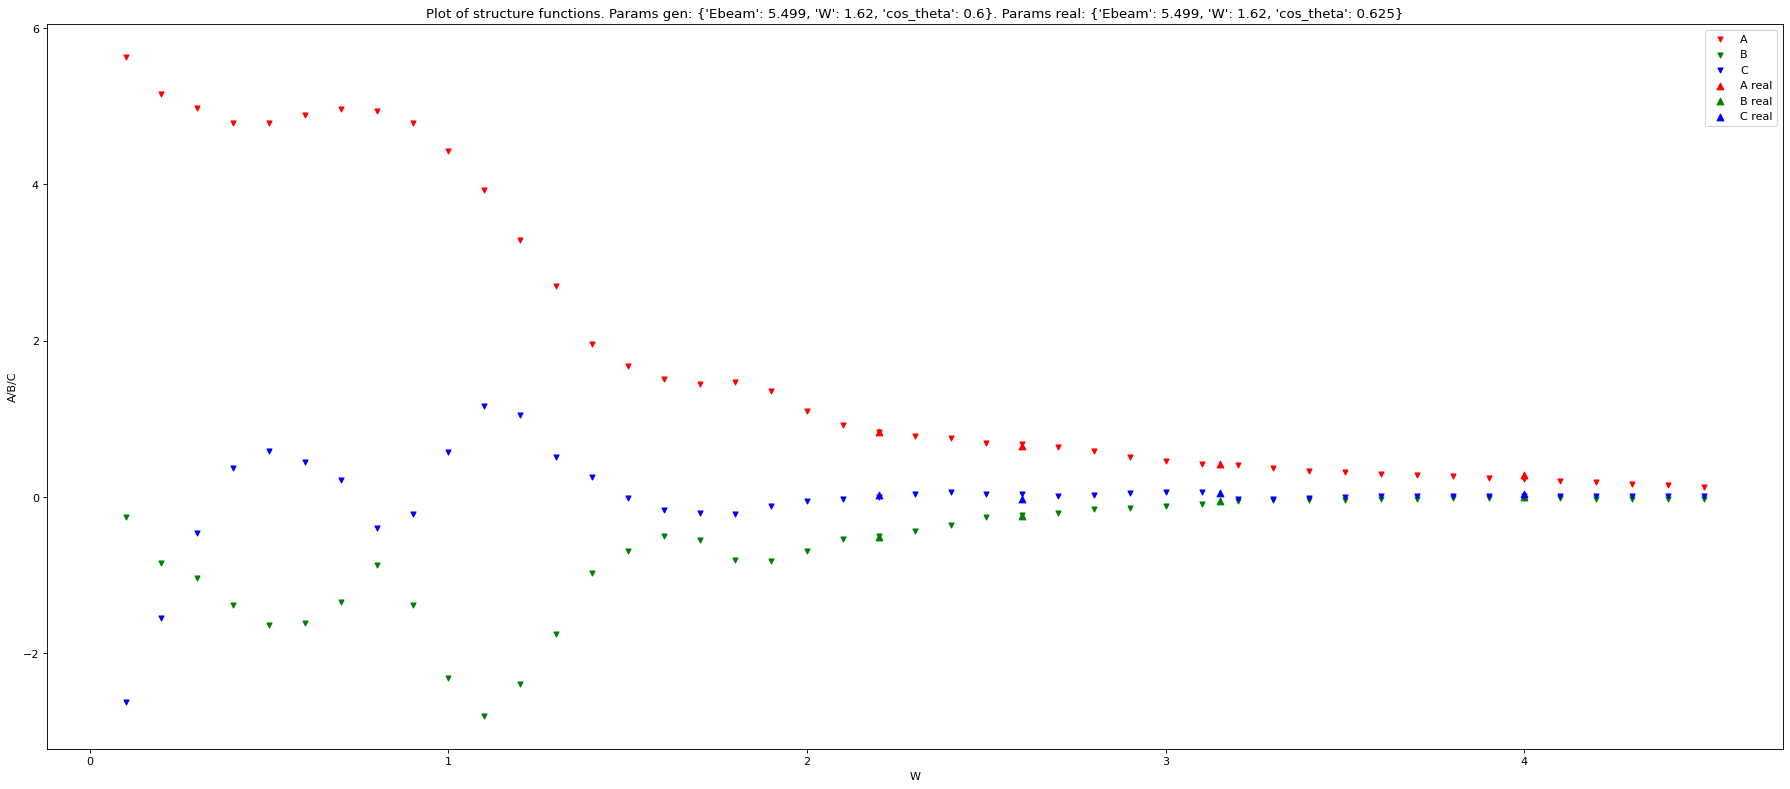

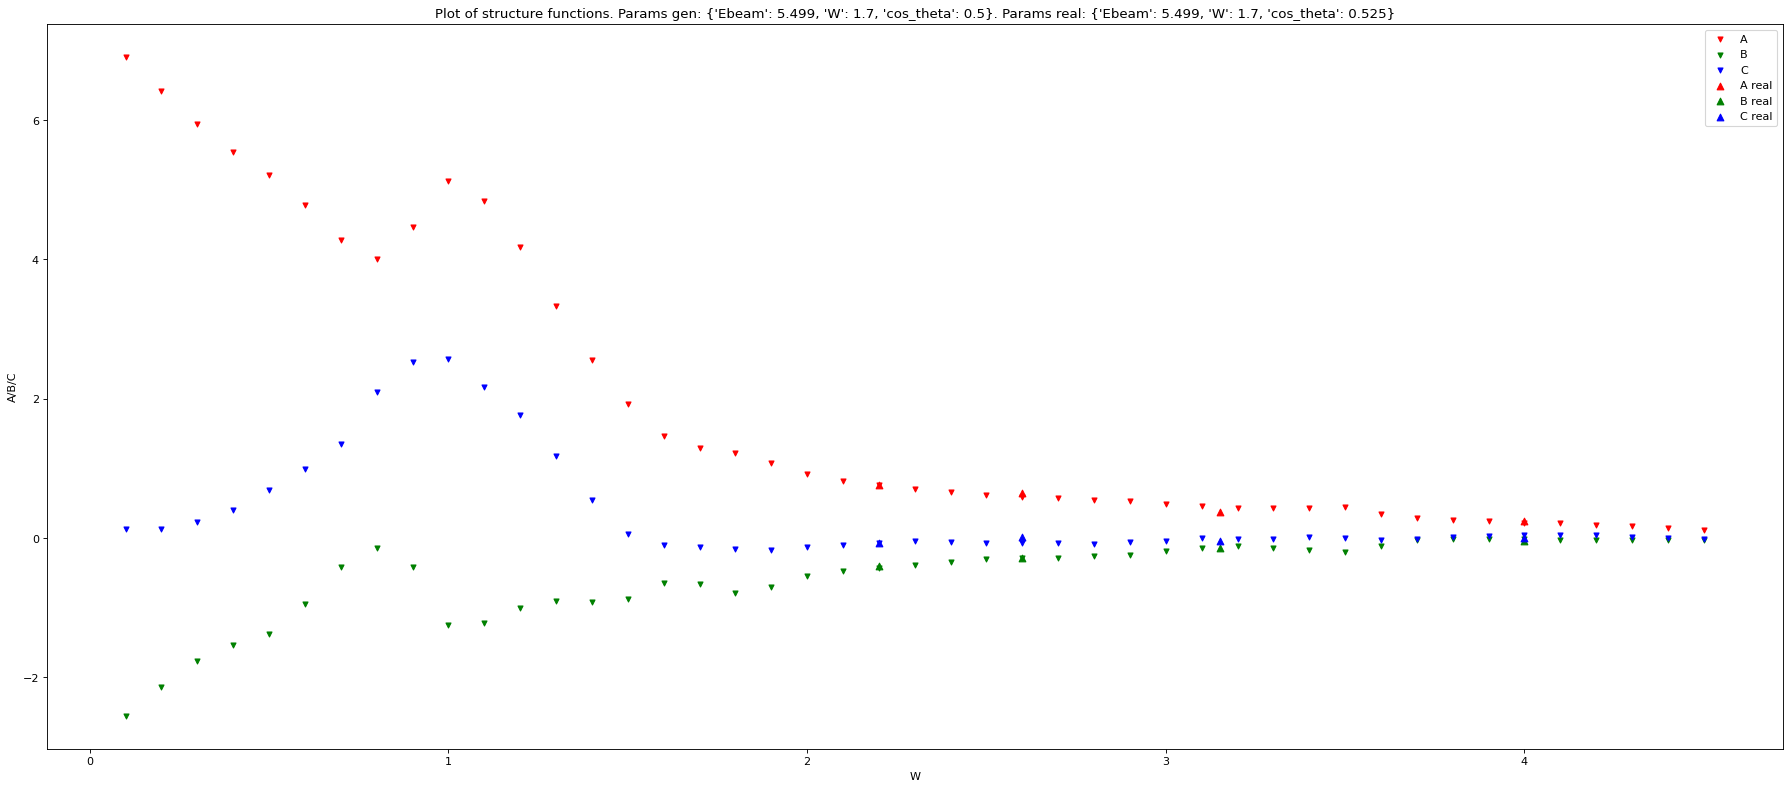

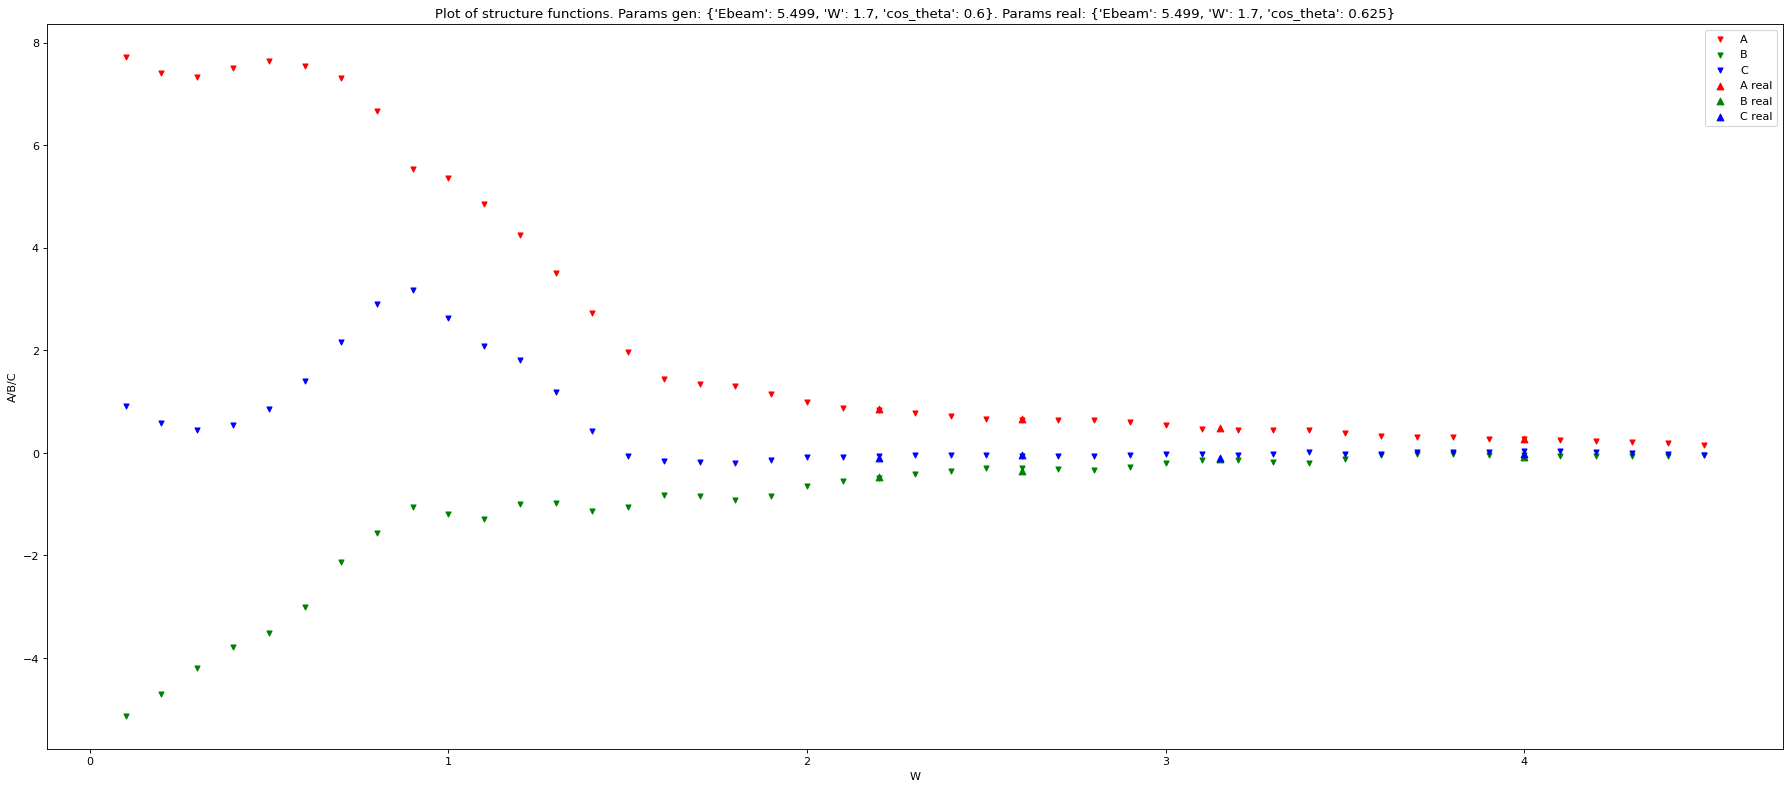

In [172]:
for i in range(2):
    for j in range(2):
        params_gen = {'Ebeam' : Ebeam,
                'W' : W_gen[i],
                'cos_theta' : cos_theta_gen[j]}

        params_real = {'Ebeam' : Ebeam,
                    'W' : W_real[i],
                    'cos_theta' : cos_theta_real[j]}
        plot_gen_real(params_gen, params_real)

# As a function of cos_theta

In [173]:
W_real = [1.62, 1.7, 1.95]
W_gen = [1.62, 1.7, 1.95]

Q2_real = [1.8, 2.6, 3.15]
Q2_gen = [1.8, 2.6, 3.1]

In [174]:
def gen_ABC_cos(Ebeam, W, Q2):
    
    df_tmp = df_grid[(df_grid.Ebeam == Ebeam)&
                    (df_grid.W == W)&
                    (df_grid.Q2 == Q2)].drop(['phi', 'dsigma_dOmega_predicted'], axis=1).drop_duplicates()
    
    return df_tmp

In [175]:
def real_ABC_cos(Ebeam, W, Q2):
    
    def func_cos(x, a, b, c): 
        return a + b*np.cos(2*x) + c*np.cos(x) 
    
    def get_real_abc(phi, dsigma_dOmega):
        try:
            xdata = phi
            ydata = dsigma_dOmega 
            popt, pcov = curve_fit(func_cos, xdata, ydata) 
            a, b, c = popt[0], popt[1], popt[2]
        except:
            a, b, c = 0, 0, 0
    
        return [a, b, c]
    
    df_tmp_real = df[(df.Ebeam == Ebeam)&
                (df.W == W)&
                (df.Q2 == Q2)].drop_duplicates()
    
    df_cos_abc = df_tmp_real.groupby('cos_theta').apply(lambda x: get_real_abc(x.phi, x.dsigma_dOmega)).reset_index()
    
    df_cos_abc['A'] = df_cos_abc[0].apply(lambda x: x[0])
    df_cos_abc['B'] = df_cos_abc[0].apply(lambda x: x[1])
    df_cos_abc['C'] = df_cos_abc[0].apply(lambda x: x[2])
    
    return df_cos_abc

In [176]:
def plot_gen_real(params_gen, params_real):
    
    df_ABC_cos_gen = gen_ABC_cos(**params_gen)
    df_ABC_cos_real = real_ABC_cos(**params_real)
    
    
    plt.figure(figsize=(28, 12), dpi=80)

    plt.scatter(df_ABC_cos_gen.cos_theta, df_ABC_cos_gen.A, label= 'A', color='red', s=20, marker='v')
    plt.scatter(df_ABC_cos_gen.cos_theta, df_ABC_cos_gen.B, label= 'B', color='green', s=20, marker='v')
    plt.scatter(df_ABC_cos_gen.cos_theta, df_ABC_cos_gen.C, label= 'C', color='blue', s=20, marker='v')

    plt.scatter(df_ABC_cos_real.cos_theta[1:], df_ABC_cos_real.A[1:], label= 'A real', color='red', marker='^')
    plt.scatter(df_ABC_cos_real.cos_theta[1:], df_ABC_cos_real.B[1:], label= 'B real', color='green', marker='^')
    plt.scatter(df_ABC_cos_real.cos_theta[1:], df_ABC_cos_real.C[1:], label= 'C real', color='blue', marker='^')

    plt.xlabel("W")
    plt.ylabel("A/B/C")
    plt.title(f'Plot of structure functions. Params gen: {params_gen}. Params real: {params_real}')
    plt.legend()
    plt.show()

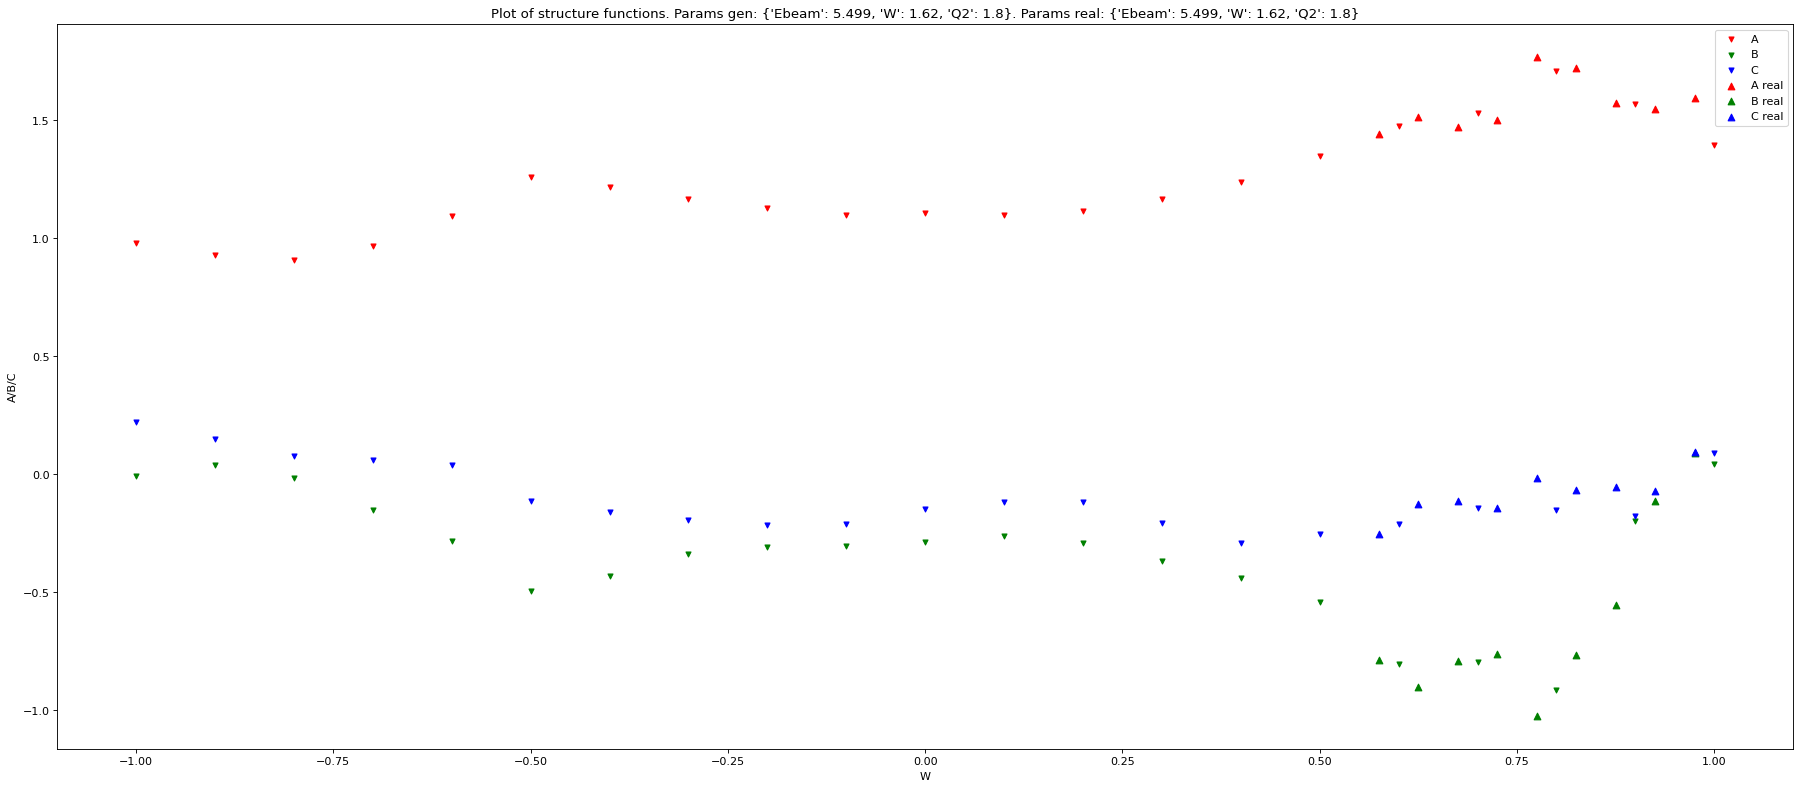

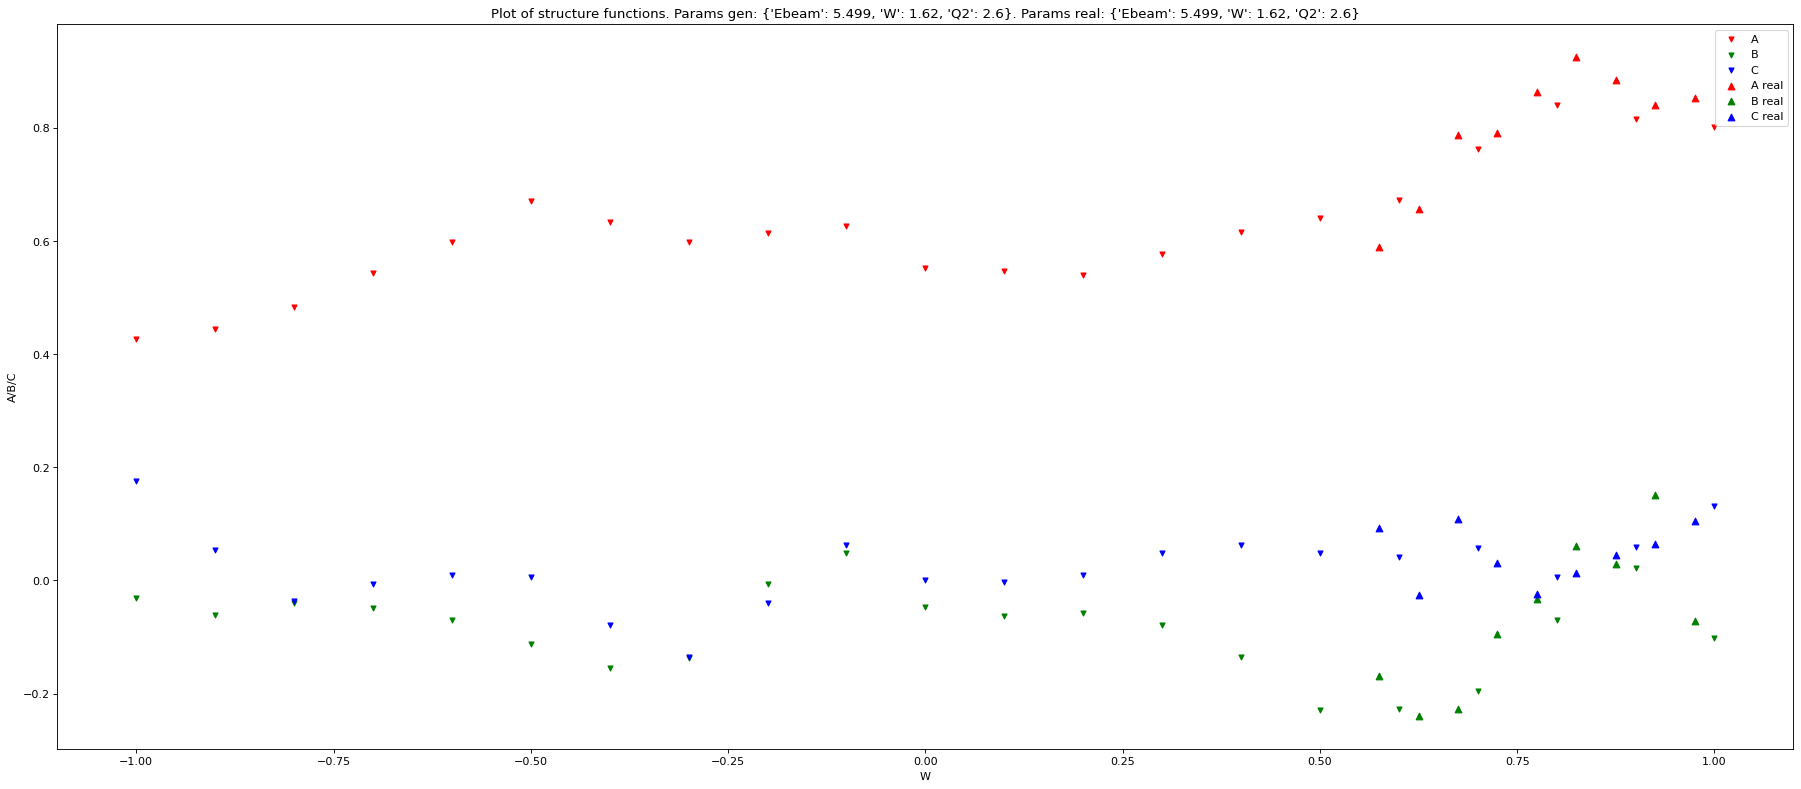

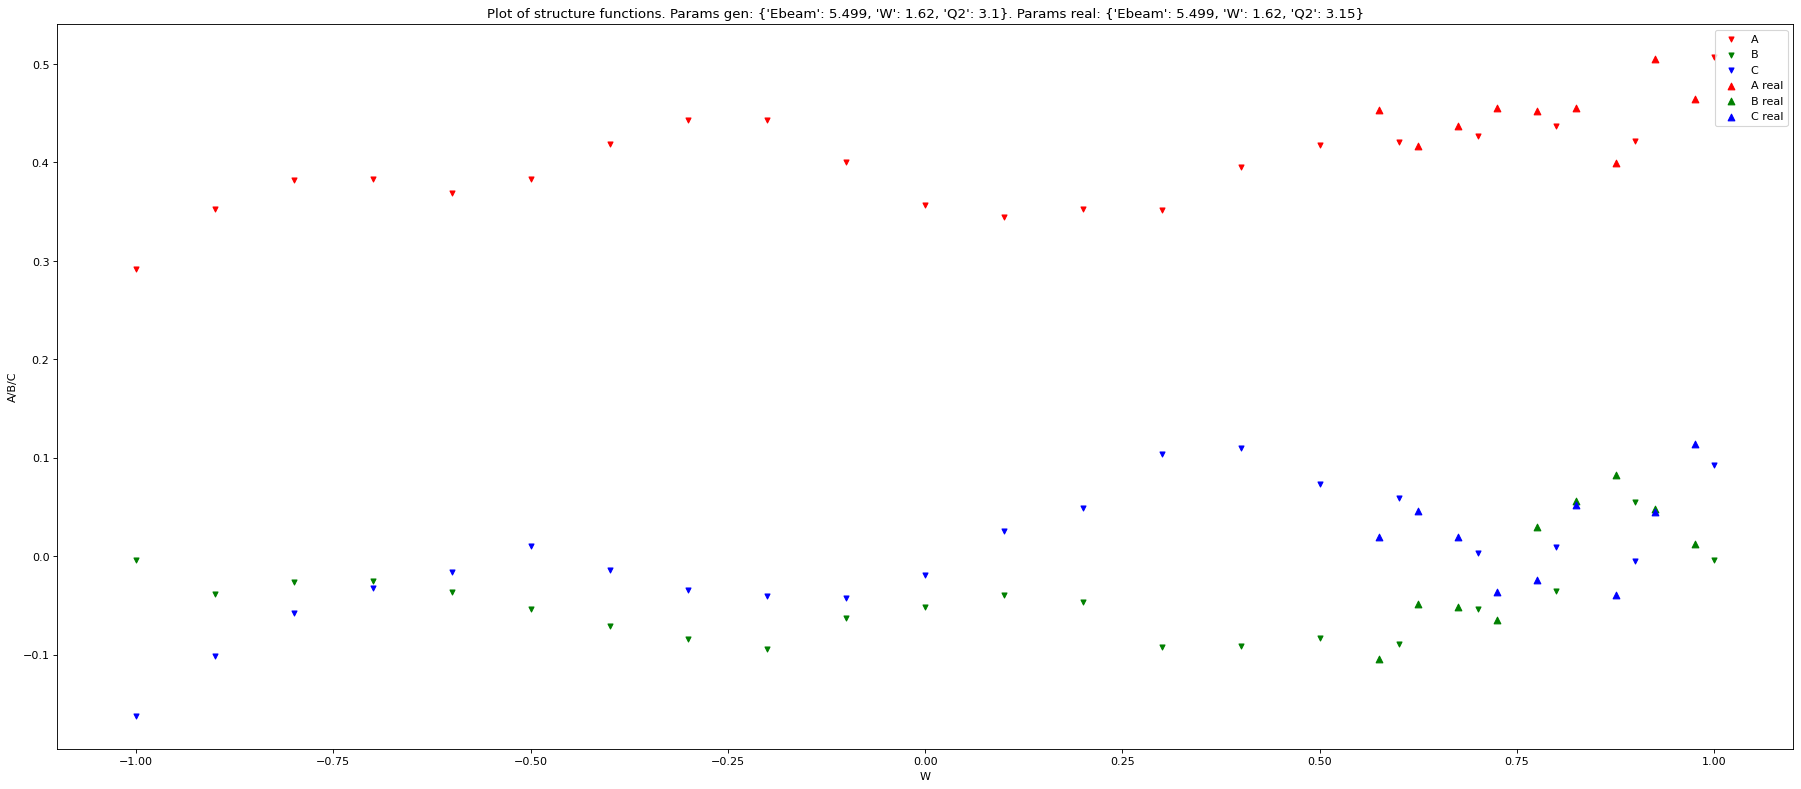

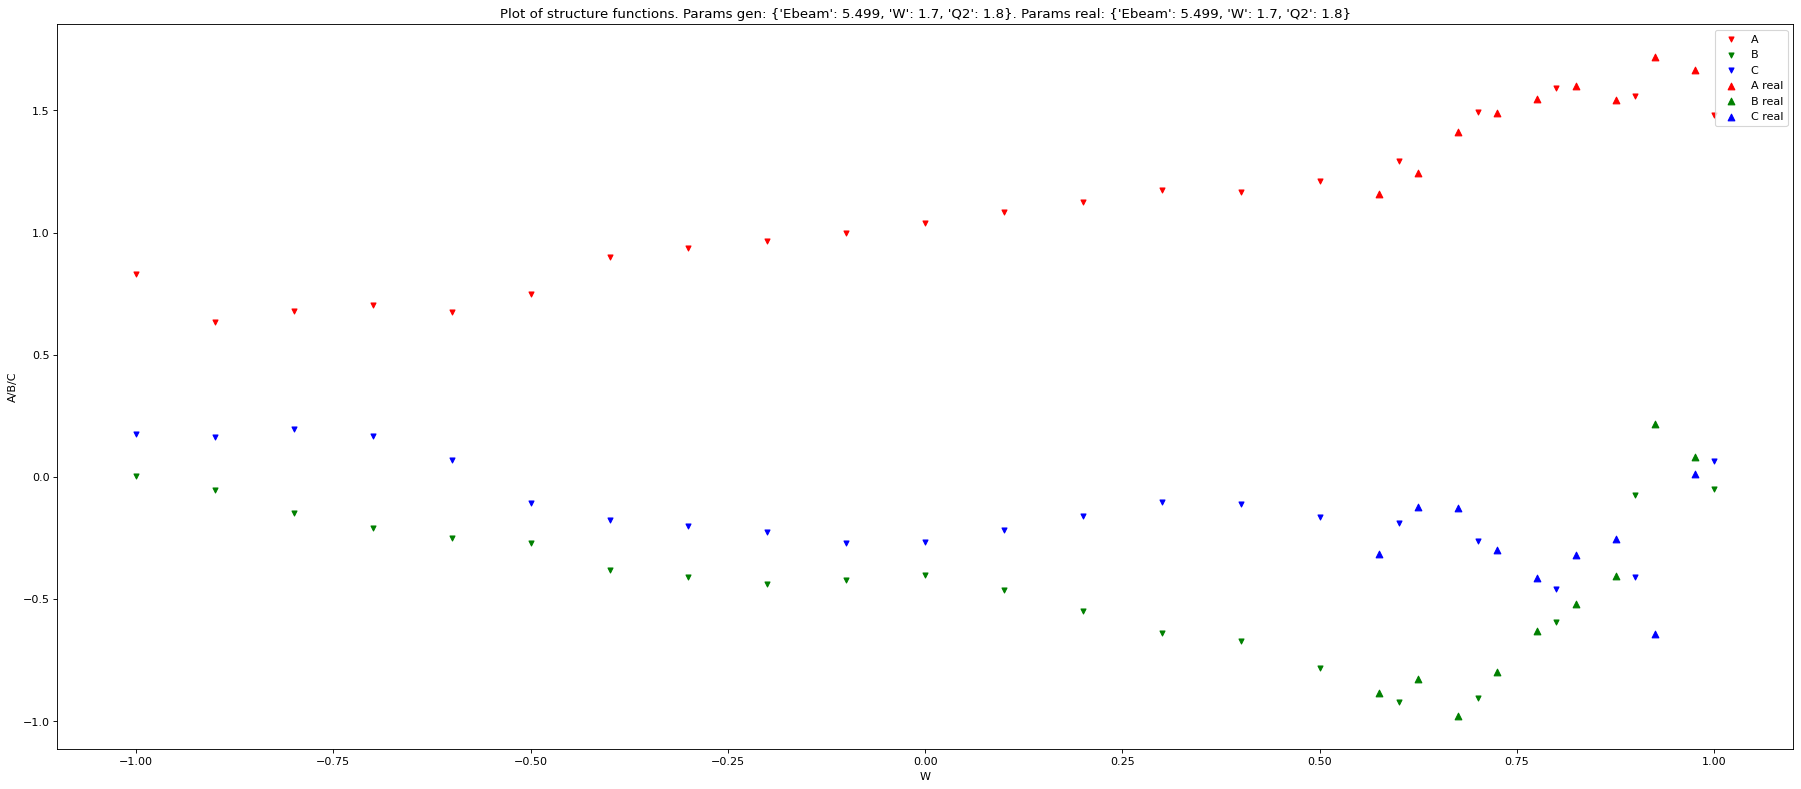

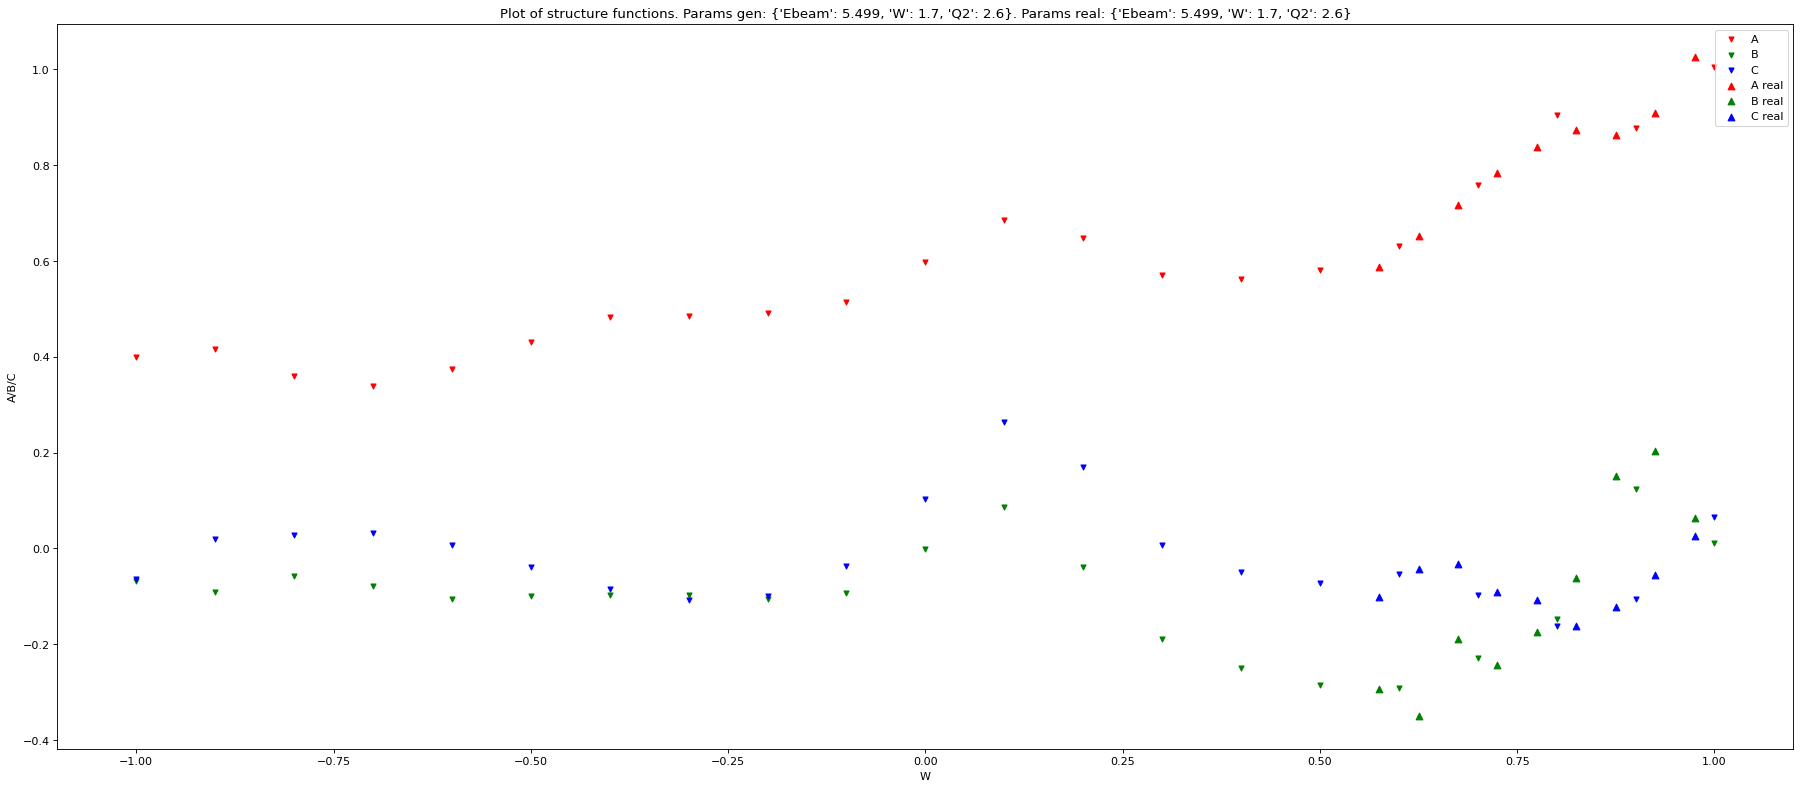

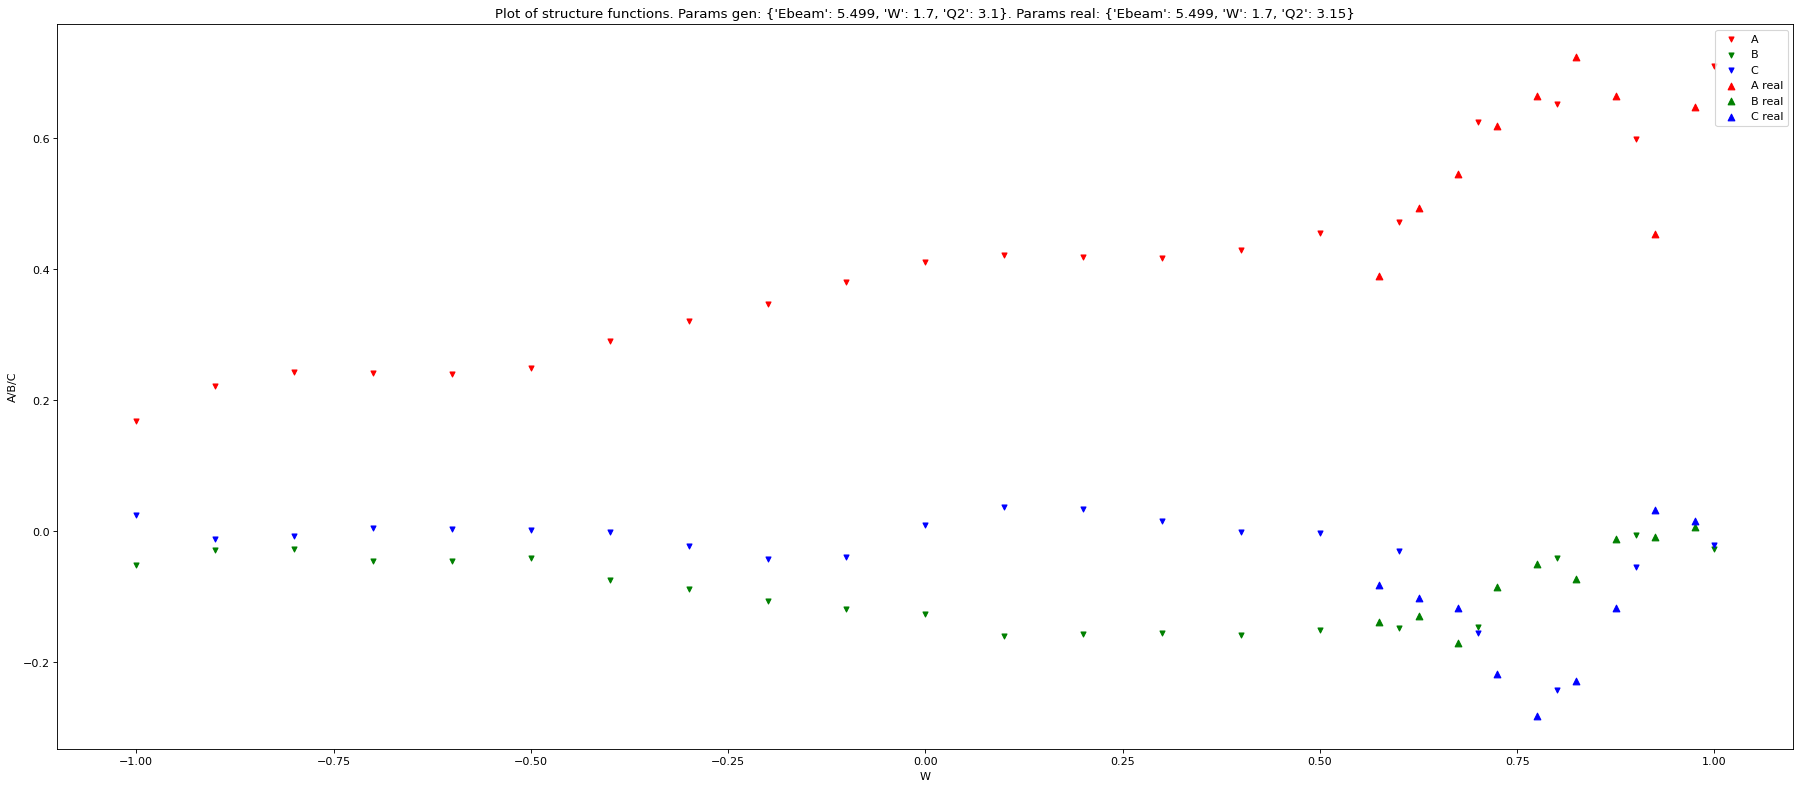

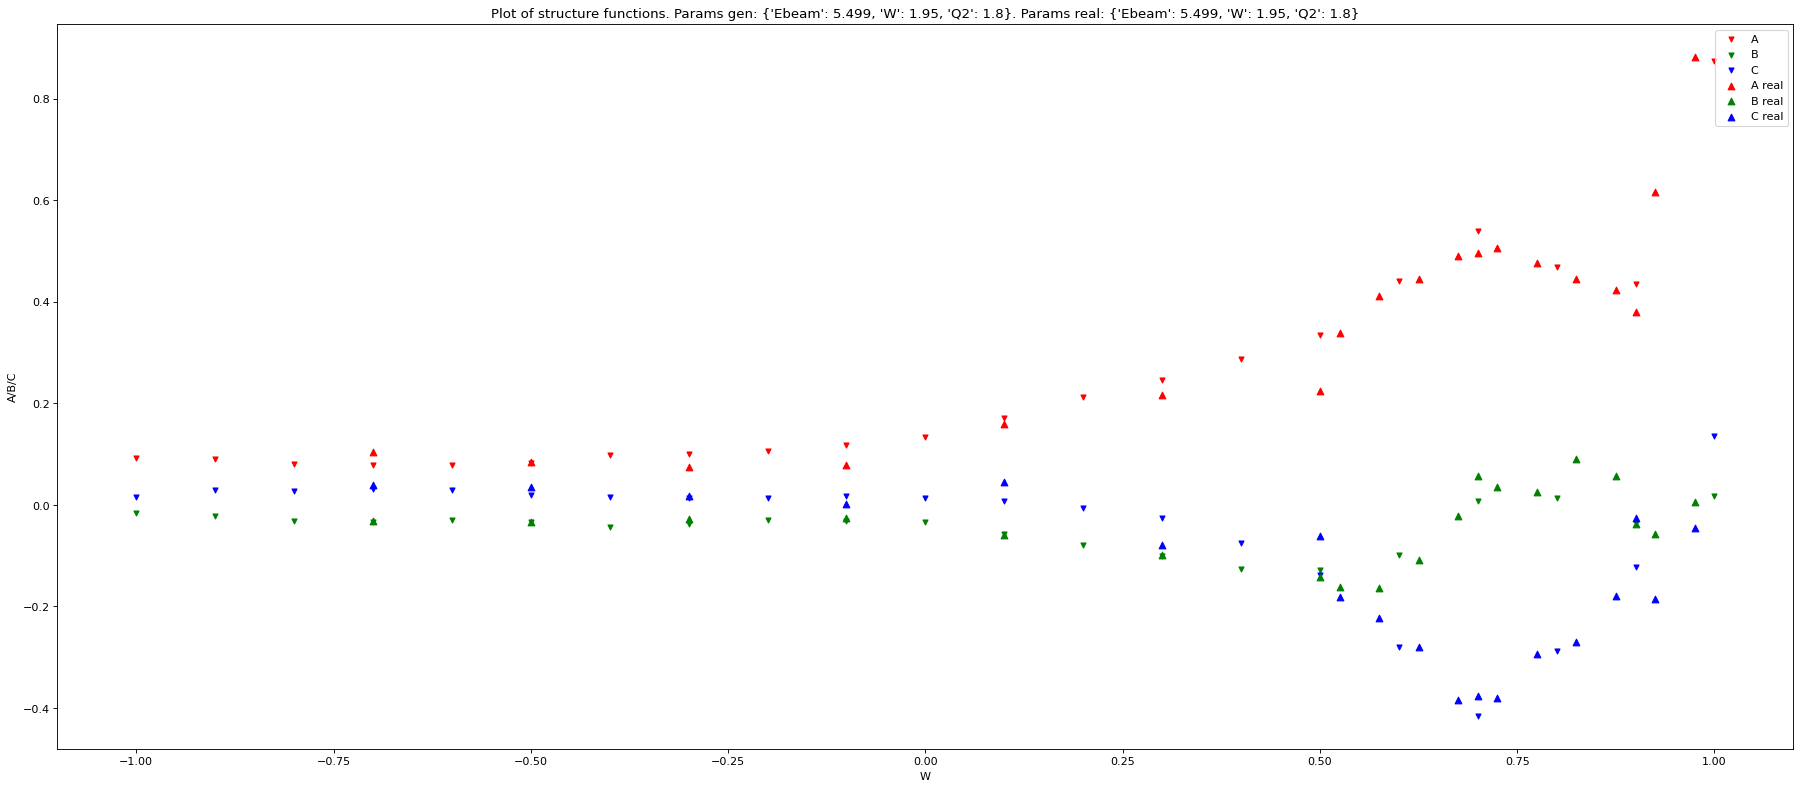

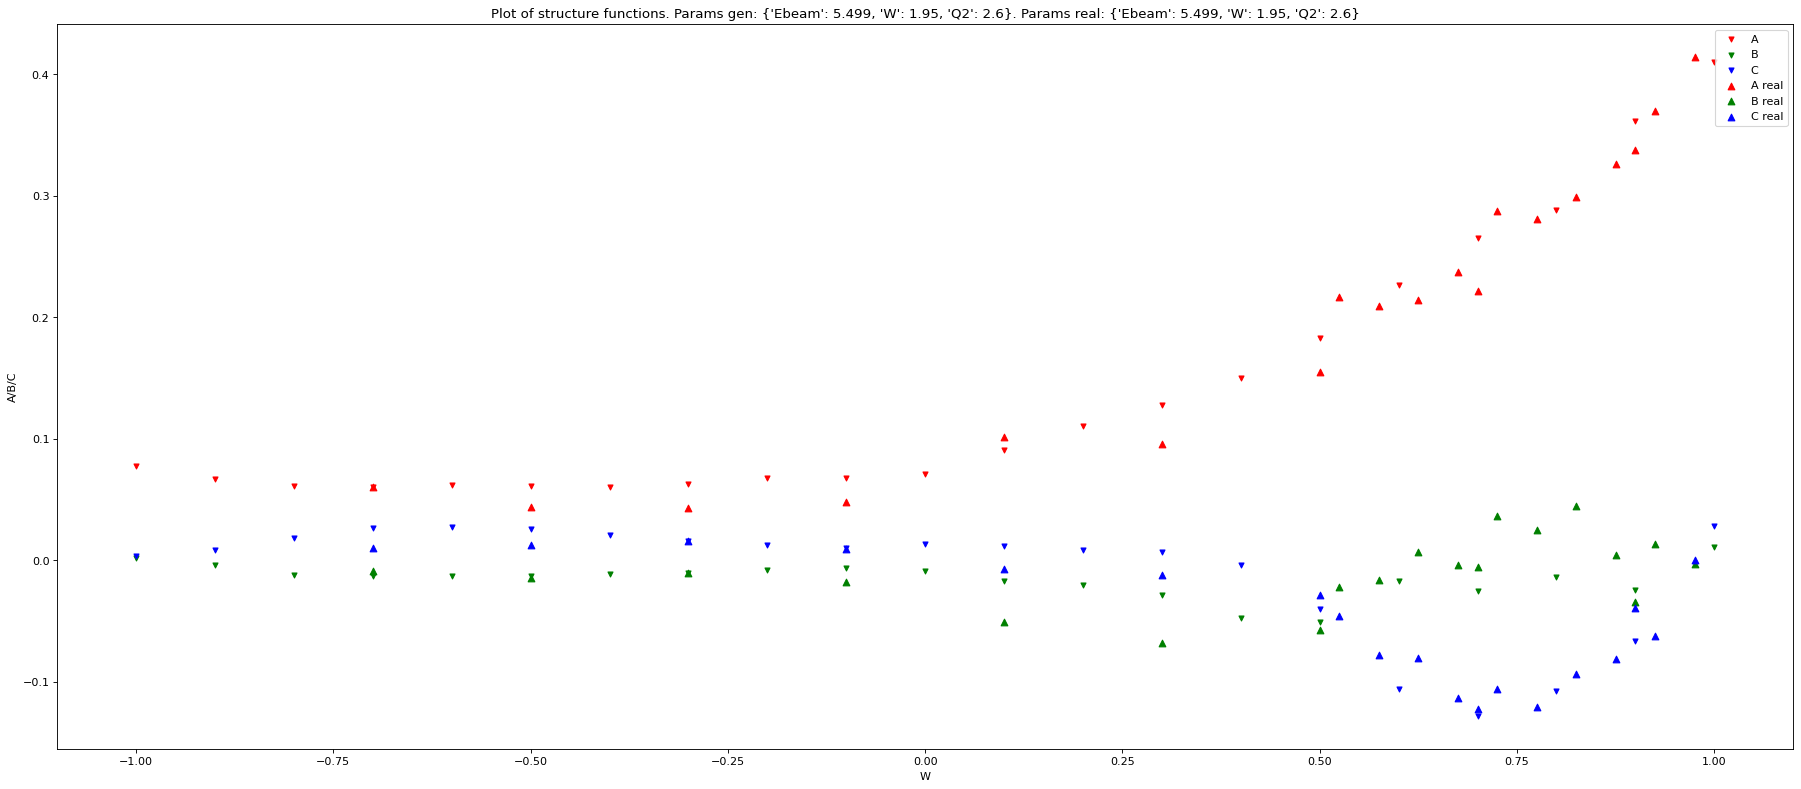

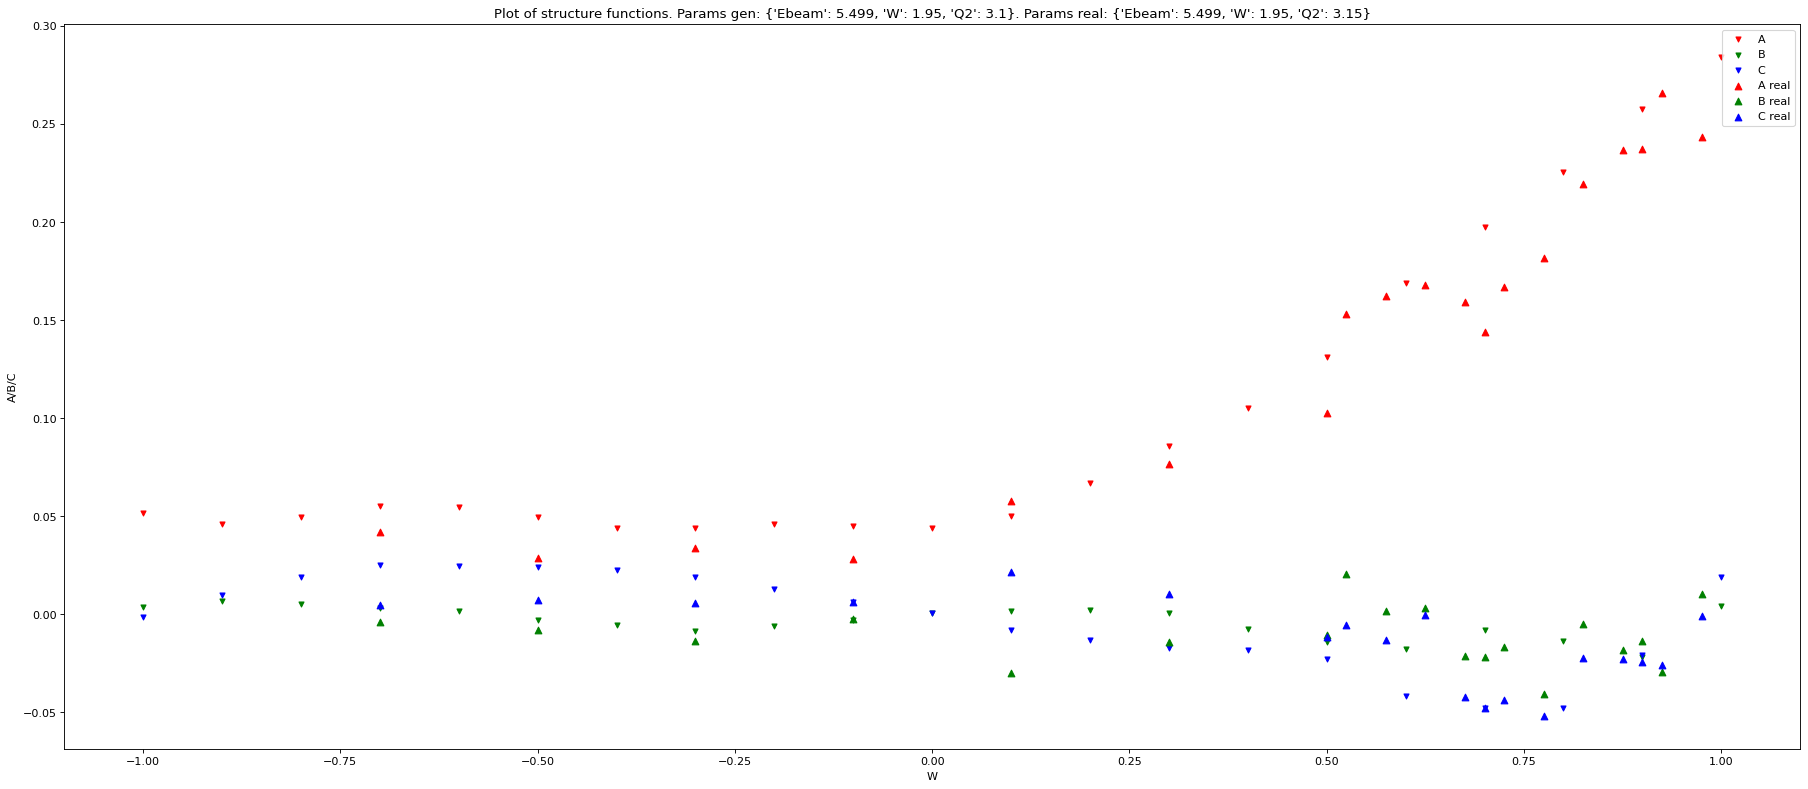

In [177]:
for i in range(3):
    for j in range(3):
        params_gen = {'Ebeam' : Ebeam,
                'W' : W_gen[i],
                'Q2' : Q2_gen[j]}

        params_real = {'Ebeam' : Ebeam,
                    'W' : W_real[i],
                    'Q2' : Q2_real[j]}
        
        try:
            plot_gen_real(params_gen, params_real)
        except:
            pass

In [156]:
# df[(df.Ebeam == 5.754)&
#     (df.W == 1.21)&
#     (np.round(df.phi, 1) == 3)&
#     (np.round(df.cos_theta,1)==0.7)]

# df_grid[(df_grid.Ebeam == 5.754)&
#        (df_grid.W == 1.21)&
#        (df_grid.phi == 3)&
#        (np.round(df_grid.cos_theta,1)==0.7)]